# **CIS 5450 Final Project - NYC Dining Safety Prediction**
*Brandon Kee, Tommy Leo, Luyao Wu*

**Presentation Video Link:** https://www.youtube.com/watch?v=2APF_ggph58

**NOTE:** The Plotly graphics do not render in the downloaded ipynb so we have provided screen recordings of each plot on Gradescope titled with the matching section number.

#Part 1: Introduction

**Project Overview:** For our final project, we aim to address food safety in New York City by predicting the health inspection results of food establishments. The primary objective is to develop a multi-class classification model that can predict the inspection grade (A, B, or C) of a restaurant based on various features such as location, cuisine type, and inspection history.

**Objective & Value:** The ability to preemptively identify at-risk restaurants can provide significant value to both the Department of Health and Mental Hygiene (DOHMH) and the general public. For regulators, this model can help optimize inspection schedules and resource allocation. For consumers, it offers transparency and helps in making informed dining decisions.

**Data Source:** We are utilizing the DOHMH New York City Restaurant Inspection Results dataset, which contains detailed records of violations, grades, and scores. We augmented this with demographic data from the NYC Census and NYC 311 Service Request data to capture a holistic view of the factors influencing food safety compliance.

**Methodology:** We will begin by cleaning the raw dataset, handling missing values, and standardizing inconsistent records. Following exploratory data analysis (EDA) to understand the distribution of grades across boroughs and cuisines, we will engineer features such as inspection frequency and violation severity. Finally, we will implement and evaluate machine learning models, including Logistic Regression, Random Forest, and XGBoost, to predict the target variable: Inspection Grade.


#Part 2: Data Loading & Preprocessing

In [1]:
# Import libraries
!pip install -q gdown
import gdown
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import numpy as np
import duckdb

###2.1: DOHMH New York City Restaurant Inspection Dataset

####2.1.1: Loading The Data & Data Analysis

To determine which factors most heavily influence sanitary compliance of NYC restaurants, we began by exploring the official record of violations. The DOHMH New York City Restaurant Inspection Dataset was uploaded to Google Drive and then is downloaded using `gdown` to be read into a dataframe.

In [2]:
# Download dataset from Drive
file_id = '1uyyWvR6gVxNu9VyHmRnTSej95XpqJWFj'
url = f'https://drive.google.com/uc?id={file_id}'

gdown.download(url, 'Inspection.csv', quiet=False)

inspection_df = pd.read_csv('Inspection.csv')





Downloading...
From (original): https://drive.google.com/uc?id=1uyyWvR6gVxNu9VyHmRnTSej95XpqJWFj
From (redirected): https://drive.google.com/uc?id=1uyyWvR6gVxNu9VyHmRnTSej95XpqJWFj&confirm=t&uuid=6deecaae-d1b9-4afd-aefd-4b16f1753eca
To: /content/Inspection.csv
100%|██████████| 142M/142M [00:00<00:00, 186MB/s]


To better understand the data, the datatypes of the columns, descriptive statistics, and the first five entries of the table are displayed below.

In [3]:
# Column datatypes
inspection_df.dtypes

CAMIS                      int64
DBA                       object
BORO                      object
BUILDING                  object
STREET                    object
ZIPCODE                  float64
PHONE                     object
CUISINE DESCRIPTION       object
INSPECTION DATE           object
ACTION                    object
VIOLATION CODE            object
VIOLATION DESCRIPTION     object
CRITICAL FLAG             object
SCORE                    float64
GRADE                     object
GRADE DATE                object
RECORD DATE               object
INSPECTION TYPE           object
Latitude                 float64
Longitude                float64
Community Board          float64
Council District         float64
Census Tract             float64
BIN                      float64
BBL                      float64
NTA                       object
Location                  object
dtype: object

From examining these columns, we noticed that the column titles have mixed capitalization patterns, so we decided to standardize this by making each title fully capitalized.

In [4]:
# Turn each column title into uppercase
inspection_df.columns = inspection_df.columns.str.upper()

In [5]:
# Descriptive statistics
inspection_df.describe()

CAMIS        ZIPCODE          SCORE       LATITUDE  \
count  2.917050e+05  288528.000000  275295.000000  291156.000000   
mean   4.797987e+07   10705.668850      25.022045      40.313655   
std    3.804861e+06     595.312665      18.769476       4.087546   
min    3.007544e+07    6605.000000       0.000000       0.000000   
25%    5.000201e+07   10023.000000      12.000000      40.685950   
50%    5.008775e+07   11101.000000      21.000000      40.732606   
75%    5.012596e+07   11232.000000      33.000000      40.761301   
max    5.017879e+07   28217.000000     203.000000      40.912822   

           LONGITUDE  COMMUNITY BOARD  COUNCIL DISTRICT   CENSUS TRACT  \
count  291156.000000    287582.000000     287590.000000  287590.000000   
mean      -73.188425       254.767517         20.613102   29838.248340   
std         7.420206       130.360304         15.711354   31260.211304   
min       -74.249101       101.000000          1.000000     100.000000   
25%       -73.988695       106.000000          4.000000    8000.000000   
50%       -73.956029       302.000000         20.000000   17300.000000   
75%       -73.894174       401.000000         34.000000   42400.000000   
max         0.000000       595.000000         51.000000  162100.000000   

                BIN           BBL  
count  2.861480e+05  2.905440e+05  
mean   2.581693e+06  2.474824e+09  
std    1.354088e+06  1.338135e+09  
min    1.000000e+06  1.000000e+00  
25%    1.051462e+06  1.011150e+09  
50%    3.020923e+06  3.007840e+09  
75%    4.010761e+06  4.006210e+09  
max    5.799501e+06  5.270001e+09

In [6]:
# First 5 columns of inspection data
inspection_df.head()

CAMIS                                         DBA       BORO BUILDING  \
0  50167878                       GOLDEN STEAMER I INC.  Manhattan      143   
1  50168599                         THAI FLAVOR 88 INC.  Manhattan      174   
2  50162584                               COZY TEA LOFT          0      141   
3  50174672  EL PALENQUE MEXICAN RESTAURANT CORPORATION   Brooklyn      181   
4  50155679                        ZADDY'S JERK CHICKEN   Brooklyn      686   

            STREET  ZIPCODE       PHONE CUISINE DESCRIPTION INSPECTION DATE  \
0      MOTT STREET  10013.0  6465231688                 NaN      01/01/1900   
1         2 AVENUE  10003.0  2122542868                 NaN      01/01/1900   
2   STATE ROUTE 27   8820.0  3472619435                 NaN      01/01/1900   
3  WEST END AVENUE  11235.0  7182553580                 NaN      01/01/1900   
4   HEGEMAN AVENUE  11207.0  7187752616                 NaN      01/01/1900   

  ACTION  ... INSPECTION TYPE   LATITUDE  LONGITUDE  COMMUNITY BOARD  \
0    NaN  ...             NaN  40.718681 -73.996645            102.0   
1    NaN  ...             NaN  40.730464 -73.986296            103.0   
2    NaN  ...             NaN        NaN        NaN              NaN   
3    NaN  ...             NaN  40.577340 -73.952961            315.0   
4    NaN  ...             NaN  40.662080 -73.886624            305.0   

  COUNCIL DISTRICT CENSUS TRACT        BIN           BBL   NTA  \
0              1.0       4100.0  1079581.0  1.002370e+09  MN24   
1              2.0       4000.0  1077704.0  1.004530e+09  MN22   
2              NaN          NaN        NaN           NaN   NaN   
3             48.0      62000.0  3245985.0  3.087320e+09  BK17   
4             42.0     110400.0  3097445.0  3.043290e+09  BK82   

                                   LOCATION  
0  POINT (-73.996645049413 40.718681310365)  
1  POINT (-73.986296382711 40.730463823842)  
2                                       NaN  
3  POINT (-73.952961276652 40.577340234075)  
4  POINT (-73.886623536611 40.662080196538)  

[5 rows x 27 columns]

Looking at the first five rows, we noticed a number of missing values and observed that the `INSPECTION DATE` column consistently showed the date 01/01/1900. According to the DOHMH website, this date indicates that the establishment is new and has not yet undergone an inspection. Since our analysis focuses only on restaurants that have already received a health inspection, we chose to retain only the rows where the `INSPECTION DATE` is not equal to 01/01/1900.

In [7]:
# Drop rows that do not have an inspection yet
inspection_df_cleaned = inspection_df[inspection_df['INSPECTION DATE'] != '01/01/1900']

In [8]:
# Check that uninspected restaurants are removed
inspection_df_cleaned.head()

CAMIS               DBA       BORO BUILDING            STREET  ZIPCODE  \
12  50070543             CLARO  Manhattan      284          3 AVENUE  10010.0   
19  41708524  REICHENBACH HALL  Manhattan        5  WEST   37 STREET  10018.0   
22  41086967           IL SOLE  Manhattan   229233    DYCKMAN STREET      NaN   
33  50070454           Sushi Q      Bronx     1610     CROSBY AVENUE  10461.0   
38  41486460        RIVER DELI   Brooklyn     2834    COLUMBIA PLACE      NaN   

         PHONE CUISINE DESCRIPTION INSPECTION DATE  \
12  3477213126             Mexican      09/23/2022   
19  2123027744              German      05/09/2024   
22  2125440406             Italian      01/04/2024   
33  7188221627            Japanese      06/24/2024   
38  7182549200             Italian      06/20/2024   

                                             ACTION  ...  \
12  Violations were cited in the following area(s).  ...   
19  Violations were cited in the following area(s).  ...   
22  Violations were cited in the following area(s).  ...   
33                Establishment re-opened by DOHMH.  ...   
38  Violations were cited in the following area(s).  ...   

                            INSPECTION TYPE   LATITUDE  LONGITUDE  \
12         Cycle Inspection / Re-inspection  40.738316 -73.983531   
19         Cycle Inspection / Re-inspection  40.750585 -73.983744   
22    Cycle Inspection / Initial Inspection   0.000000   0.000000   
33  Cycle Inspection / Reopening Inspection  40.844217 -73.830521   
38    Cycle Inspection / Initial Inspection   0.000000   0.000000   

    COMMUNITY BOARD COUNCIL DISTRICT CENSUS TRACT        BIN           BBL  \
12            106.0              2.0       6800.0  1018020.0  1.008780e+09   
19            105.0              4.0       8400.0  1080734.0  1.008390e+09   
22              NaN              NaN          NaN        NaN  1.000000e+00   
33            210.0             13.0      26602.0  2098281.0  2.041680e+09   
38              NaN              NaN          NaN        NaN  3.000000e+00   

     NTA                                  LOCATION  
12  MN21    POINT (-73.98353061908 40.73831623132)  
19  MN17  POINT (-73.983744126629 40.750585348897)  
22   NaN                                       NaN  
33  BX10  POINT (-73.830521390885 40.844216634976)  
38   NaN                                       NaN  

[5 rows x 27 columns]

We then investigated the unique values of columns where there were multiple rows with the same value of that column.

In [9]:
# Unique values of BORO
inspection_df_cleaned['BORO'].unique()

array(['Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

In [10]:
# Unique values of ACTION
inspection_df_cleaned['ACTION'].unique()

array(['Violations were cited in the following area(s).',
       'Establishment re-opened by DOHMH.',
       'No violations were recorded at the time of this inspection.',
       'Establishment re-closed by DOHMH.',
       'Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.'],
      dtype=object)

In [11]:
# Unique values of INSPECTION TYPE
inspection_df_cleaned['INSPECTION TYPE'].unique()

array(['Cycle Inspection / Re-inspection',
       'Cycle Inspection / Initial Inspection',
       'Cycle Inspection / Reopening Inspection',
       'Smoke-Free Air Act / Initial Inspection',
       'Administrative Miscellaneous / Initial Inspection',
       'Calorie Posting / Initial Inspection',
       'Inter-Agency Task Force / Initial Inspection',
       'Pre-permit (Operational) / Initial Inspection',
       'Pre-permit (Operational) / Reopening Inspection',
       'Pre-permit (Operational) / Compliance Inspection',
       'Pre-permit (Operational) / Re-inspection',
       'Administrative Miscellaneous / Compliance Inspection',
       'Administrative Miscellaneous / Re-inspection',
       'Pre-permit (Non-operational) / Initial Inspection',
       'Sodium Warning / Initial Inspection',
       'Cycle Inspection / Compliance Inspection',
       'Pre-permit (Non-operational) / Re-inspection',
       'Trans Fat / Re-inspection',
       'Administrative Miscellaneous / Reopening Inspecti

In [12]:
# Unique values of VIOLATION CODE
inspection_df_cleaned['VIOLATION CODE'].unique()

array(['02B', '09B', nan, '04L', '10E', '06F', '08A', '09E', '04M', '10J',
       '06E', '09C', '20-08', '04A', '03C', '15-39', '03I', '20F', '15E2',
       '10G', '18-11', '10H', '16J', '05A', '02G', '20-04', '10F', '04N',
       '10B', '10D', '06C', '04O', '04H', '05F', '06D', '02H', '06B',
       '08C', '28-06', '05D', '09A', '03B', '15-21', '10A', '28-03',
       '04J', '19-06', '20-06', '04C', '06A', '16-02', '05C', '15-42',
       '06G', '02C', '18-14', '08B', '03A', '15-27', '19-05', '04K',
       '04E', '20-01', '19-10', '05E', '28-05', '05H', '28-04', '16B',
       '10I', '28-01', '19-07', '20-05', '15-37', '02A', '04P', '16-03',
       '18-01', '02F', '04D', '04F', '16-04', '20A', '16-06', '15I',
       '02I', '28-07', '20-02', '16-10', '02D', '20D', '22A', '05B',
       '03E', '20E', '10C', '06I', '19-04', '22F', '22C', '22G', '19-08',
       '15-22', '16D', '15F2', '18-12', '15-01', '19-11', '22E', '15L',
       '16-08', '04B', '15F6', '03D', '06H', '15E3', '16C', '09D', '0

In [13]:
# Cuisine decription unique values
inspection_df_cleaned['CUISINE DESCRIPTION'].unique()

array(['Mexican', 'German', 'Italian', 'Japanese', 'Latin American',
       'Chinese', 'Middle Eastern', 'Pizza', 'American', 'Donuts',
       'French', 'Creole', 'Frozen Desserts', 'Indian', 'Soul Food',
       'Korean', 'Seafood', 'Bakery Products/Desserts', 'Continental',
       'Coffee/Tea', 'Bottled Beverages', 'Jewish/Kosher', 'Hamburgers',
       'Caribbean', 'Bagels/Pretzels', 'Sandwiches', 'Other',
       'Mediterranean', 'Asian/Asian Fusion', 'Moroccan', 'Barbecue',
       'Chicken', 'Peruvian', 'Thai', 'Spanish', 'African', 'Polish',
       'Bangladeshi', 'Tex-Mex', 'Chinese/Japanese', 'Southeast Asian',
       'Ethiopian', 'Hotdogs', 'Tapas', 'Sandwiches/Salads/Mixed Buffet',
       'Juice, Smoothies, Fruit Salads', 'Irish', 'Fusion', 'Salads',
       'Greek', 'Russian', 'Hotdogs/Pretzels', 'Soups/Salads/Sandwiches',
       'Vegan', 'Pancakes/Waffles', 'Filipino', 'Eastern European',
       'Turkish', 'Vegetarian', 'Hawaiian', 'New American', 'Brazilian',
       'Pakistani'

####2.1.2: Dropping Columns & Nulls

Dropping `LOCATION`: This column was dropped because it contains information about longitude and latitude and there are already separate columns for both of them. Since this data is already represented in their respective columns, we decided to drop the duplicate information in the `LOCATION` column.

In [14]:
# Drop the LOCATION column
inspection_df_cleaned = inspection_df_cleaned.drop(columns=['LOCATION'])

Dropping `COUNCIL DISTRICT` and `COMMUNITY BOARD`: These columns were dropped because the relevant information is present in the `BORO` and `ZIPCODE` columns, which can be used to analyze different areas restaurants are located in. We also do not plan on extracting any information regarding political boundaries or using this as a potential feature for our models, so `COUNCIL DISTRICT` will not be of use.

In [15]:
# Drop the COUNCIL DISTRICT and COMMUNITY BOARD columns
inspection_df_cleaned = inspection_df_cleaned.drop(columns=['COUNCIL DISTRICT', 'COMMUNITY BOARD'])

Dropping `BIN` and `BBL`: Building Identification Number and Borough-Block-Lot were dropped as these columns were redundant since we already have 'CAMIS' and geographical information like `LONGITUDE` and `LATITUDE` in other columns, which are more representative of location.

In [16]:
# Drop the BIN and BBL
inspection_df_cleaned = inspection_df_cleaned.drop(columns=['BIN', 'BBL'])

Finally, we dropped all rows that had null values.

In [17]:
# Drop all rows with null values
inspection_df_cleaned = inspection_df_cleaned.dropna()

#### 2.1.3: Data Standardization & Cleaning

After inspecting the unique values of columns with repeating values, we noticed that several steps could be taken to clean and standardize this data, including changing the data types and grouping data into more concise categories, which will be implemented throughout this section.

Each of the columns that represent a date (`INSPECTION DATE`, `GRADE DATE`, `RECORD DATE`) were converted to Datetime format for standardization and make it easier to access values of each date (i.e. month, year, etc.)

In [18]:
# Convert date columns to Datetime format
inspection_df_cleaned['INSPECTION DATE'] = pd.to_datetime(inspection_df_cleaned['INSPECTION DATE'])
inspection_df_cleaned['GRADE DATE'] = pd.to_datetime(inspection_df_cleaned['GRADE DATE'])
inspection_df_cleaned['RECORD DATE'] = pd.to_datetime(inspection_df_cleaned['RECORD DATE'])

We noticed that streets used inconsistent abbreviations ('AVE', 'AVENUE', 'ST', 'STREET') so we sought to standardize these by making each abbreviation into the fully spelled out representation.

In [19]:
# Standardize street abbreviations using regex
import re

def standardize_street(street):
    if pd.isna(street):
        return None
    street = str(street).upper()
    street = re.sub(r'\bST\.?\b', 'STREET', street)
    street = re.sub(r'\bAVE\.?\b', 'AVENUE', street)
    street = re.sub(r'\bRD\.?\b', 'ROAD', street)
    return street.strip()

inspection_df_cleaned['STREET'] = inspection_df_cleaned['STREET'].apply(standardize_street)

There were over 50 different types of `CUISINE DESCRIPTION` in our data, so we wanted to reduce the number of categories by mapping each cuisine into more concise groupings. After applying this mapping, we were able to recuce the number of unique descriptions to 15.

In [20]:
# Map CUISINE DESCRIPTION to broader groupings

inspection_df_cleaned['CUISINE DESCRIPTION'] = inspection_df_cleaned['CUISINE DESCRIPTION'].str.lower().str.strip()

cuisine_map = {
    'pakistani': 'south asian', 'indian': 'south asian', 'bangladeshi': 'south asian',

    'japanese': 'east/southeast asian', 'korean': 'east/southeast asian', 'thai': 'east/southeast asian',
    'southeast asian': 'east/southeast asian', 'filipino': 'east/southeast asian',
    'indonesian': 'east/southeast asian', 'chinese/japanese': 'east/southeast asian',
    'chinese': 'east/southeast asian', 'hawaiian': 'east/southeast asian',

    'mexican': 'mexican/tex-mex', 'tex-mex': 'mexican/tex-mex',

    'greek': 'middle eastern/med', 'middle eastern': 'middle eastern/med', 'turkish': 'middle eastern/med',
    'iranian': 'middle eastern/med', 'moroccan': 'middle eastern/med', 'lebanese': 'middle eastern/med',
    'afghan': 'middle eastern/med', 'armenian': 'middle eastern/med', 'polynesian': 'middle eastern/med',

    'peruvian': 'latin american', 'brazilian': 'latin american', 'chilean': 'latin american',
    'latin american': 'latin american',

    'ethiopian': 'african', 'african': 'african',

    'pizza': 'italian/pizza', 'italian': 'italian/pizza',

    'new american': 'american', 'continental': 'american', 'hamburgers': 'american',
    'hotdogs': 'american', 'hotdogs/pretzels': 'american', 'soul food': 'american',
    'barbecue': 'american', 'american': 'american', 'californian': 'american', 'southwestern': 'american',

    'new french': 'french',

    'donuts': 'desserts & bakery', 'bakery products/desserts': 'desserts & bakery',
    'frozen desserts': 'desserts & bakery', 'bagels/pretzels': 'desserts & bakery',
    'nuts/confectionary': 'desserts & bakery',

    'coffee/tea': 'beverages & juices', 'juice, smoothies, fruit salads': 'beverages & juices',
    'bottled beverages': 'beverages & juices', 'fruits/vegetables': 'beverages & juices',

    'sandwiches': 'deli', 'salads': 'deli', 'soups': 'deli',
    'soups/salads/sandwiches': 'deli', 'sandwiches/salads/mixed buffet': 'deli',
    'pancakes/waffles': 'deli',

    'steakhouses': 'specialty/other', 'jewish/kosher': 'specialty/other', 'vegan': 'specialty/other',
    'vegetarian': 'specialty/other', 'tapas': 'specialty/other', 'eastern european': 'specialty/other',
    'russian': 'specialty/other', 'irish': 'specialty/other', 'german': 'specialty/other',
    'creole': 'specialty/other', 'cajun': 'specialty/other', 'creole/cajun': 'specialty/other',
    'fusion': 'specialty/other', 'not listed/not applicable': 'specialty/other', 'other': 'specialty/other',
    'english': 'specialty/other', 'egyptian': 'specialty/other', 'czech': 'specialty/other',
    'basque': 'specialty/other', 'haute cuisine': 'specialty/other', 'chimichurri': 'specialty/other',
    'chilean': 'latin american',
    'caribbean': 'caribbean'
}

inspection_df_cleaned['CUISINE DESCRIPTION'] = inspection_df_cleaned['CUISINE DESCRIPTION'].replace(cuisine_map)

The `INSPECTION TYPE` column contained values in the form of sentences, which would be difficult to use for looking up rows based on the inspection type. We condensed these sentences into one of four grouped inspection types in the `INSPECTION TYPE GROUPED` column, reducing the number of different inspection types.

In [21]:
# Change INSPECTION TYPE to a single keyword

inspection_df_cleaned['INSPECTION TYPE GROUPED'] = inspection_df_cleaned['INSPECTION TYPE'].str.lower()

# Complaint
inspection_df_cleaned.loc[
    inspection_df_cleaned['INSPECTION TYPE GROUPED'].str.contains('complaint'),
    'INSPECTION TYPE GROUPED'
] = 'Complaint'

# Re-inspection
inspection_df_cleaned.loc[
    inspection_df_cleaned['INSPECTION TYPE GROUPED'].str.contains('re-?inspection|re-opening'),
    'INSPECTION TYPE GROUPED'
] = 'Re-inspection'

# Administrative Rules
inspection_df_cleaned.loc[
    inspection_df_cleaned['INSPECTION TYPE GROUPED'].str.contains('administrative|smoke-free|transfat|calorie'),
    'INSPECTION TYPE GROUPED'
] = 'Administrative/Other'

# Cycle Inspection
remaining_condition = ~inspection_df_cleaned['INSPECTION TYPE GROUPED'].isin(['Complaint', 'Re-inspection', 'Administrative/Other'])

inspection_df_cleaned.loc[
    remaining_condition,
    'INSPECTION TYPE GROUPED'
] = 'Cycle Inspection'

The original `INSPECTION TYPE` column can now be dropped with the implementation of the `INSPECTION TYPE GROUPED` column that now holds all the relevant information.

In [22]:
# Drop original INSPECTION TYPE column
inspection_df_cleaned = inspection_df_cleaned.drop(columns=['INSPECTION TYPE'])

After inspecting the unique values in the `GRADE` column, we filtered the data to retain only entries with grades of A, B, or C. We excluded grades Z and P, which indicate pending status, to ensure our dataset contains only finalized grades.

In [23]:
# Unique values of GRADE
inspection_df_cleaned['GRADE'].unique()

array(['A', 'C', 'B', 'Z', 'P'], dtype=object)

In [24]:
# Only keep entries with GRADE A, B, or C
inspection_df_cleaned = inspection_df_cleaned[
    (inspection_df_cleaned['GRADE'] == 'A') |
    (inspection_df_cleaned['GRADE'] == 'B' )|
    (inspection_df_cleaned['GRADE'] == 'C')]

We then mapped the `ACTION` column to a single word in order to not store sentences as values of this column and make it easier to filter and lookup by a keyword for later queries.

In [25]:
# Map actions to single word descriptions
action_map = {
  'Violations were cited in the following area(s).': 'violation',
  'Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.': 'closed',
  'Establishment re-opened by DOHMH.': 'reopened',
  'No violations were recorded at the time of this inspection.': 'none'
}

inspection_df_cleaned['ACTION'] = inspection_df_cleaned['ACTION'].map(action_map)

The `CRITICAL FLAG` column values were changed to a value of Y if critical, and N otherwise, simplifying to a binary format to further reduce dimensionality.

In [26]:
# Convert CRITICAL FLAG to Y or N
inspection_df_cleaned['CRITICAL FLAG'] = np.where(inspection_df_cleaned['CRITICAL FLAG'] == 'Critical', 'Y', 'N')

Two new colums, `FLAG_SUM` and `TOTAL_INSPECTIONS` were added to store the cumulative number of critical flags a restaurant received prior to the current inspection and the total number of times the restaurant was inspected prior to the current date, respectively.

In [27]:
# Calculate total number of inspections and sum of critical flags for each restaurant
import duckdb

restaurant_features_df = duckdb.sql("""
    SELECT
        CAMIS,
        "INSPECTION DATE",

        COALESCE(
            SUM(CASE WHEN UPPER("CRITICAL FLAG") = 'Y' THEN 1 ELSE 0 END)
            OVER (
                PARTITION BY CAMIS
                ORDER BY "INSPECTION DATE"
                ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
            ),
            0
        ) AS FLAG_SUM,

        COUNT(*)
            OVER (
                PARTITION BY CAMIS
                ORDER BY "INSPECTION DATE"
                ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
            ) AS TOTAL_INSPECTIONS

    FROM inspection_df_cleaned
""").df()


In [28]:
# Remove duplicate rows
restaurant_features_df = restaurant_features_df.drop_duplicates(
    subset=["CAMIS", "INSPECTION DATE"]
)

restaurant_features_df.head()

CAMIS INSPECTION DATE  FLAG_SUM  TOTAL_INSPECTIONS
0  40362432      2022-10-25       0.0                  0
2  40362432      2024-11-12       1.0                  2
4  40364296      2024-03-04       0.0                  0
7  40364296      2025-03-20       1.0                  3
9  40364715      2023-03-23       0.0                  0

The `RESTAURANT_DENSITY` of each of the zipcodes was also calculated to get a sense of how many restraunts are in a given zipcode.

In [29]:
# Calculate restaurant density for each zipcode
area_features_df = duckdb.sql("""
    SELECT
        ZIPCODE,
        COUNT(DISTINCT CAMIS) AS RESTAURANT_DENSITY
    FROM inspection_df_cleaned
    GROUP BY ZIPCODE
""").df()

print(area_features_df.head())

   ZIPCODE  RESTAURANT_DENSITY
0  11231.0                 153
1  11365.0                  52
2  11216.0                 189
3  11212.0                 104
4  11209.0                 237


These newly formed dataframes were then merged with the existing cleaned inspection dataframe to form the finalized inspection dataframe, which now contains columns with aggregate calculations.

In [30]:
# Merge the dataframes from above
inspection_df_cleaned = pd.merge(
    inspection_df_cleaned,
    restaurant_features_df,
    on=['CAMIS', 'INSPECTION DATE'],
    how='left'
)
inspection_df_cleaned = pd.merge(
    inspection_df_cleaned,
    area_features_df,
    on='ZIPCODE',
    how='left'
)

In [31]:
# Change the values of BORO to lowercase for easy matching with other datasets
inspection_df_cleaned['BORO'] = inspection_df_cleaned['BORO'].str.lower()

In [32]:
# Display first 5 rows of cleaned dataframe
inspection_df_cleaned.head()

CAMIS               DBA       BORO BUILDING            STREET  ZIPCODE  \
0  50070543             CLARO  manhattan      284          3 AVENUE  10010.0   
1  41708524  REICHENBACH HALL  manhattan        5  WEST   37 STREET  10018.0   
2  41464542        SEVEN SINS  manhattan      293          3 AVENUE  10010.0   
3  41715927            GRUPPO  manhattan       98          AVENUE B  10009.0   
4  50144293     BLUE MOUNTAIN  manhattan      396          3 AVENUE  10016.0   

        PHONE   CUISINE DESCRIPTION INSPECTION DATE     ACTION  ...  \
0  3477213126       mexican/tex-mex      2022-09-23  violation  ...   
1  2123027744       specialty/other      2024-05-09  violation  ...   
2  6466492389              american      2024-12-12  violation  ...   
3  2129952100         italian/pizza      2023-11-16  violation  ...   
4  9173622982  east/southeast asian      2025-10-23  violation  ...   

  GRADE DATE RECORD DATE   LATITUDE  LONGITUDE CENSUS TRACT   NTA  \
0 2022-09-23  2025-11-07  40.738316 -73.983531       6800.0  MN21   
1 2024-05-09  2025-11-07  40.750585 -73.983744       8400.0  MN17   
2 2024-12-12  2025-11-07  40.738547 -73.983336       6400.0  MN21   
3 2023-11-16  2025-11-07  40.724694 -73.981496       3200.0  MN22   
4 2025-10-23  2025-11-07  40.742104 -73.980769       7200.0  MN20   

  INSPECTION TYPE GROUPED  FLAG_SUM  TOTAL_INSPECTIONS  RESTAURANT_DENSITY  
0           Re-inspection       0.0                  0                 217  
1           Re-inspection       1.0                  1                 368  
2           Re-inspection       0.0                  0                 217  
3        Cycle Inspection       1.0                  2                 271  
4           Re-inspection       1.0                  1                 372  

[5 rows x 25 columns]

###2.2: NYC Census Dataset

#### 2.2.1: Loading the Data & Data Analysis

To begin our socioeconomic analysis, we needed reliable demographic data to complement the restaurant inspections. For this, the New York City Census Dataset was uploaded to Google Drive and then is downloaded using `gdown` to be read into a dataframe. Similar to the previous section, the column datatypes and descriptive statistics were examined to get an overall view of the data.

In [33]:
# Download dataset from Drive
file_id = '1DdsoXMamaHTsdcf3thaJcjtp42yogkIZ'
url = f'https://drive.google.com/uc?id={file_id}'

gdown.download(url, 'Census.csv', quiet=False)

census_df = pd.read_csv('Census.csv')

Downloading...
From: https://drive.google.com/uc?id=1DdsoXMamaHTsdcf3thaJcjtp42yogkIZ
To: /content/Census.csv
100%|██████████| 408k/408k [00:00<00:00, 85.8MB/s]


In [34]:
# Data types of the columns
census_df.dtypes

CensusTract          int64
County              object
Borough             object
TotalPop             int64
Men                  int64
Women                int64
Hispanic           float64
White              float64
Black              float64
Native             float64
Asian              float64
Citizen              int64
Income             float64
IncomeErr          float64
IncomePerCap       float64
IncomePerCapErr    float64
Poverty            float64
ChildPoverty       float64
Professional       float64
Service            float64
Office             float64
Construction       float64
Production         float64
Drive              float64
Carpool            float64
Transit            float64
Walk               float64
OtherTransp        float64
WorkAtHome         float64
MeanCommute        float64
Employed             int64
PrivateWork        float64
PublicWork         float64
SelfEmployed       float64
FamilyWork         float64
Unemployment       float64
dtype: object

In [35]:
# Descriptive statistics
census_df.describe()

CensusTract      TotalPop           Men         Women     Hispanic  \
count  2.167000e+03   2167.000000   2167.000000   2167.000000  2128.000000   
mean   3.605476e+10   3888.667743   1852.812183   2035.855561    26.624671   
std    2.594875e+07   2240.050968   1063.921420   1212.765249    22.662106   
min    3.600500e+10      0.000000      0.000000      0.000000     0.000000   
25%    3.604703e+10   2359.500000   1113.000000   1224.500000     9.000000   
50%    3.604712e+10   3550.000000   1699.000000   1848.000000    18.400000   
75%    3.608103e+10   4957.500000   2360.500000   2571.500000    39.900000   
max    3.608599e+10  28926.000000  13460.000000  15466.000000   100.000000   

             White        Black       Native        Asian       Citizen  ...  \
count  2128.000000  2128.000000  2128.000000  2128.000000   2167.000000  ...   
mean     33.055827    23.950799     0.198590    13.442622   2436.468389  ...   
std      30.421463    29.476758     0.700418    16.446275   1538.399585  ...   
min       0.000000     0.000000     0.000000     0.000000      0.000000  ...   
25%       4.100000     1.500000     0.000000     2.100000   1446.000000  ...   
50%      22.950000     7.800000     0.000000     6.700000   2140.000000  ...   
75%      60.100000    39.075000     0.000000    18.925000   2976.000000  ...   
max     100.000000   100.000000    11.300000    89.800000  22905.000000  ...   

              Walk  OtherTransp   WorkAtHome  MeanCommute      Employed  \
count  2124.000000  2124.000000  2124.000000  2106.000000   2167.000000   
mean      9.048070     2.306921     3.749105    40.831576   1813.498385   
std       9.623892     2.872501     4.560174     7.105916   1180.593180   
min       0.000000     0.000000     0.000000    15.200000      0.000000   
25%       3.300000     0.500000     1.300000    37.200000   1052.500000   
50%       6.500000     1.500000     2.800000    41.400000   1579.000000   
75%      10.800000     3.200000     5.100000    45.375000   2273.500000   
max     100.000000    55.600000   100.000000    70.500000  12780.000000   

       PrivateWork  PublicWork  SelfEmployed   FamilyWork  Unemployment  
count  2124.000000  2124.00000   2124.000000  2124.000000   2125.000000  
mean     79.536205    14.19355      6.151271     0.118644      9.757788  
std       6.923979     7.23155      3.851846     0.391563      5.786948  
min      38.600000     0.00000      0.000000     0.000000      0.000000  
25%      75.000000     8.80000      3.500000     0.000000      5.900000  
50%      79.900000    13.30000      5.600000     0.000000      8.800000  
75%      84.400000    18.70000      8.200000     0.000000     12.600000  
max     100.000000    53.70000     61.400000     3.900000    100.000000  

[8 rows x 34 columns]

The results from above illustrated the extremes of the census data, with the TotalPop column having a minimum of 0 (likely parks or industrial zones) and a maximum of 28,926. Reviewing these distributions validated that our data captured the necessary real-world variance to train a robust model, while also flagging potential outliers like census tracts with 0 population that might require further solving later on.

In [36]:
# First 5 rows of dataframe
census_df.head()

CensusTract County Borough  TotalPop   Men  Women  Hispanic  White  Black  \
0  36005000100  Bronx   Bronx      7703  7133    570      29.9    6.1   60.9   
1  36005000200  Bronx   Bronx      5403  2659   2744      75.8    2.3   16.0   
2  36005000400  Bronx   Bronx      5915  2896   3019      62.7    3.6   30.7   
3  36005001600  Bronx   Bronx      5879  2558   3321      65.1    1.6   32.4   
4  36005001900  Bronx   Bronx      2591  1206   1385      55.4    9.0   29.0   

   Native  ...  Walk  OtherTransp  WorkAtHome  MeanCommute  Employed  \
0     0.2  ...   NaN          NaN         NaN          NaN         0   
1     0.0  ...   2.9          0.0         0.0         43.0      2308   
2     0.0  ...   1.4          0.5         2.1         45.0      2675   
3     0.0  ...   8.6          1.6         1.7         38.8      2120   
4     0.0  ...   3.0          2.4         6.2         45.4      1083   

   PrivateWork  PublicWork  SelfEmployed  FamilyWork  Unemployment  
0          NaN         NaN           NaN         NaN           NaN  
1         80.8        16.2           2.9         0.0           7.7  
2         71.7        25.3           2.5         0.6           9.5  
3         75.0        21.3           3.8         0.0           8.7  
4         76.8        15.5           7.7         0.0          19.2  

[5 rows x 36 columns]

In order to combine the census data with the inspection data, new join keys needed to be created. We first focused on isolating the relevant data within the CensusTract column. We sliced the CensusTract strings to retain only the last six characters. However, these extracted strings still contained leading zeros and text formatting that mismatched the numeric inspection keys. We addressed this by casting the strings into floating-point numbers, transforming values like "000100" into a cleaner "100.0". This final conversion resulted in a precise CENSUS_TRACT_KEY to enable an easy merge between the two datasets.

In [37]:
# Merge both datasets by creating "CensusTrac and boro" join keys.

# Extract the last 6 digits of the 11-digit CensusTract (e.g., 36005000100 → "000100")
census_df['CensusTract_6digit'] = census_df['CensusTract'].astype(str).str[-6:]
# Convert the 6-digit tract code to float for merging (e.g., "000100" → 100.0)
census_df['CENSUS_TRACT_KEY'] = census_df['CensusTract_6digit'].astype(float)

In [38]:
# Convert the 'Borough' column to lowercase to match inspection data's 'boro'
census_df['boro'] = census_df['Borough'].str.lower()

We made the strategic decision to filter the dataset down to four essential columns: CENSUS_TRACT_KEY, boro, TotalPop, and Income. By removing the excess columns, we created a focused dataset that prioritized the specific economic and population factors most likely to correlate with restaurant performance.

In [39]:
# Keep only relevant columns for merging
census_df = census_df[['CENSUS_TRACT_KEY', 'boro', 'TotalPop', 'Income']]

In [40]:
# First 5 rows of updated dataframe
census_df.head()

CENSUS_TRACT_KEY   boro  TotalPop   Income
0             100.0  bronx      7703      NaN
1             200.0  bronx      5403  72034.0
2             400.0  bronx      5915  74836.0
3            1600.0  bronx      5879  32312.0
4            1900.0  bronx      2591  37936.0

In [41]:
# Check Income column
census_df['Income']

0           NaN
1       72034.0
2       74836.0
3       32312.0
4       37936.0
         ...   
2162    76542.0
2163    25064.0
2164    22656.0
2165    56406.0
2166        NaN
Name: Income, Length: 2167, dtype: float64

In [42]:
# Unique values of boro
census_df['boro'].unique()

array(['bronx', 'brooklyn', 'manhattan', 'queens', 'staten island'],
      dtype=object)

##2.3: 311 Service Requests

#### 2.3.1: Loading The Data & Data Analysis

The New York City 311 Service Request Dataset was uploaded to Google Drive and then is downloaded using `gdown` to be read into a dataframe.

In [43]:
# Download dataset from Drive
file_id = '1az4hldTBgKl6ziXkOtIHj5r-ykqQMHv6'
url = f'https://drive.google.com/uc?id={file_id}'

gdown.download(url, 'NYC311data.csv', quiet=False)

nyc_311_df = pd.read_csv('NYC311data.csv')


Downloading...
From (original): https://drive.google.com/uc?id=1az4hldTBgKl6ziXkOtIHj5r-ykqQMHv6
From (redirected): https://drive.google.com/uc?id=1az4hldTBgKl6ziXkOtIHj5r-ykqQMHv6&confirm=t&uuid=fb383c58-1fb2-43bd-ac88-91706d0cf6fb
To: /content/NYC311data.csv
100%|██████████| 187M/187M [00:01<00:00, 124MB/s]
/tmp/ipython-input-2342004623.py:7: DtypeWarning: Columns (48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  nyc_311_df = pd.read_csv('NYC311data.csv')


In [44]:
# Display first 5 rows of dataframe
nyc_311_df.head()

Unique Key            Created Date    Closed Date Agency  \
0    32310363  12/31/2015 11:59:45 PM  01-01-16 0:55   NYPD   
1    32309934  12/31/2015 11:59:44 PM  01-01-16 1:26   NYPD   
2    32309159  12/31/2015 11:59:29 PM  01-01-16 4:51   NYPD   
3    32305098  12/31/2015 11:57:46 PM  01-01-16 7:43   NYPD   
4    32306529  12/31/2015 11:56:58 PM  01-01-16 3:24   NYPD   

                       Agency Name           Complaint Type  \
0  New York City Police Department  Noise - Street/Sidewalk   
1  New York City Police Department         Blocked Driveway   
2  New York City Police Department         Blocked Driveway   
3  New York City Police Department          Illegal Parking   
4  New York City Police Department          Illegal Parking   

                     Descriptor    Location Type  Incident Zip  \
0              Loud Music/Party  Street/Sidewalk       10034.0   
1                     No Access  Street/Sidewalk       11105.0   
2                     No Access  Street/Sidewalk       10458.0   
3  Commercial Overnight Parking  Street/Sidewalk       10461.0   
4              Blocked Sidewalk  Street/Sidewalk       11373.0   

        Incident Address  ... Bridge Highway Name Bridge Highway Direction  \
0    71 VERMILYEA AVENUE  ...                 NaN                      NaN   
1        27-07 23 AVENUE  ...                 NaN                      NaN   
2  2897 VALENTINE AVENUE  ...                 NaN                      NaN   
3    2940 BAISLEY AVENUE  ...                 NaN                      NaN   
4          87-14 57 ROAD  ...                 NaN                      NaN   

  Road Ramp Bridge Highway Segment Garage Lot Name Ferry Direction  \
0       NaN                    NaN             NaN             NaN   
1       NaN                    NaN             NaN             NaN   
2       NaN                    NaN             NaN             NaN   
3       NaN                    NaN             NaN             NaN   
4       NaN                    NaN             NaN             NaN   

  Ferry Terminal Name   Latitude  Longitude  \
0                 NaN  40.865682 -73.923501   
1                 NaN  40.775945 -73.915094   
2                 NaN  40.870325 -73.888525   
3                 NaN  40.835994 -73.828379   
4                 NaN  40.733060 -73.874170   

                                   Location  
0   (40.86568153633767, -73.92350095571744)  
1  (40.775945312321085, -73.91509393898605)  
2  (40.870324522111424, -73.88852464418646)  
3   (40.83599404683083, -73.82837939584206)  
4  (40.733059618956815, -73.87416975810375)  

[5 rows x 53 columns]

In [45]:
# Data types of the columns
nyc_311_df.dtypes

Unique Key                          int64
Created Date                       object
Closed Date                        object
Agency                             object
Agency Name                        object
Complaint Type                     object
Descriptor                         object
Location Type                      object
Incident Zip                      float64
Incident Address                   object
Street Name                        object
Cross Street 1                     object
Cross Street 2                     object
Intersection Street 1              object
Intersection Street 2              object
Address Type                       object
City                               object
Landmark                           object
Facility Type                      object
Status                             object
Due Date                           object
Resolution Description             object
Resolution Action Updated Date     object
Community Board                    object
Borough                            object
X Coordinate (State Plane)        float64
Y Coordinate (State Plane)        float64
Park Facility Name                 object
Park Borough                       object
School Name                        object
School Number                      object
School Region                      object
School Code                        object
School Phone Number                object
School Address                     object
School City                        object
School State                       object
School Zip                         object
School Not Found                   object
School or Citywide Complaint      float64
Vehicle Type                      float64
Taxi Company Borough              float64
Taxi Pick Up Location             float64
Bridge Highway Name                object
Bridge Highway Direction           object
Road Ramp                          object
Bridge Highway Segment             object
Garage Lot Name                   float64
Ferry Direction                    object
Ferry Terminal Name                object
Latitude                          float64
Longitude                         float64
Location                           object
dtype: object

In [46]:
# Descriptive statistics
nyc_311_df.describe()

Unique Key   Incident Zip  X Coordinate (State Plane)  \
count  3.006980e+05  298083.000000                2.971580e+05   
mean   3.130054e+07   10848.888645                1.004854e+06   
std    5.738547e+05     583.182081                2.175338e+04   
min    3.027948e+07      83.000000                9.133570e+05   
25%    3.080118e+07   10310.000000                9.919752e+05   
50%    3.130436e+07   11208.000000                1.003158e+06   
75%    3.178446e+07   11238.000000                1.018372e+06   
max    3.231065e+07   11697.000000                1.067173e+06   

       Y Coordinate (State Plane)  School or Citywide Complaint  Vehicle Type  \
count               297158.000000                           0.0           0.0   
mean                203754.534416                           NaN           NaN   
std                  29880.183529                           NaN           NaN   
min                 121219.000000                           NaN           NaN   
25%                 183343.000000                           NaN           NaN   
50%                 201110.500000                           NaN           NaN   
75%                 224125.250000                           NaN           NaN   
max                 271876.000000                           NaN           NaN   

       Taxi Company Borough  Taxi Pick Up Location  Garage Lot Name  \
count                   0.0                    0.0              0.0   
mean                    NaN                    NaN              NaN   
std                     NaN                    NaN              NaN   
min                     NaN                    NaN              NaN   
25%                     NaN                    NaN              NaN   
50%                     NaN                    NaN              NaN   
75%                     NaN                    NaN              NaN   
max                     NaN                    NaN              NaN   

            Latitude      Longitude  
count  297158.000000  297158.000000  
mean       40.725885     -73.925630  
std         0.082012       0.078454  
min        40.499135     -74.254937  
25%        40.669796     -73.972142  
50%        40.718661     -73.931781  
75%        40.781840     -73.876805  
max        40.912869     -73.700760

Looking at the above statistics of the 311 dataset revealed that columns like Taxi Company and Garage Lot Name were largely populated with null values. Recognizing that this empty metadata would not be of use for our processing pipeline, we only retained the `Created Date`, `Complaint Type`, `Incident Address`, `Incident Zip`, and `Borough` columns.

In [47]:
# Keep only relevant columns
nyc_311_df = nyc_311_df[['Created Date','Complaint Type',
                         'Incident Address','Incident Zip',
                         'Borough']]

In [48]:
# Drop null values
nyc_311_df_cleaned = nyc_311_df.dropna()

#### 2.3.2: Data Standardization & Cleaning

To prepare the dataset, we converted date fields into datetime format, standardized column names, and removed duplicate rows to ensure consistency and reliability.

In [50]:
# Convert Created Date to datetime format
nyc_311_df_cleaned.loc[:, 'Created Date'] = pd.to_datetime(
    nyc_311_df_cleaned['Created Date'],
    format='%Y-%m-%dT%H:%M:%S.%f',
    errors='coerce'
)

In [51]:
# Convert borough to lowercase to match previous dataframes
nyc_311_df_cleaned.loc[:, 'Borough'] = nyc_311_df_cleaned['Borough'].str.lower()

In [52]:
# Rename Unique Key to Incident ID for readability
nyc_311_df_cleaned = nyc_311_df_cleaned.rename(columns={'Unique Key': 'Incident ID'})

In [53]:
# Drop duplicate rows
nyc_311_df_cleaned = nyc_311_df_cleaned.drop_duplicates()

In [54]:
# Show first 5 rows of dataframe
nyc_311_df_cleaned.head()

Created Date           Complaint Type       Incident Address  Incident Zip  \
0          NaT  Noise - Street/Sidewalk    71 VERMILYEA AVENUE       10034.0   
1          NaT         Blocked Driveway        27-07 23 AVENUE       11105.0   
2          NaT         Blocked Driveway  2897 VALENTINE AVENUE       10458.0   
3          NaT          Illegal Parking    2940 BAISLEY AVENUE       10461.0   
4          NaT          Illegal Parking          87-14 57 ROAD       11373.0   

     Borough  
0  manhattan  
1     queens  
2      bronx  
3      bronx  
4     queens

In [55]:
# Unique values of Complaint Type
nyc_311_df_cleaned['Complaint Type'].unique()

array(['Noise - Street/Sidewalk', 'Blocked Driveway', 'Illegal Parking',
       'Derelict Vehicle', 'Noise - Commercial',
       'Noise - House of Worship', 'Posting Advertisement',
       'Animal Abuse', 'Vending', 'Noise - Vehicle', 'Drinking',
       'Traffic', 'Bike/Roller/Skate Chronic', 'Panhandling',
       'Homeless Encampment', 'Urinating in Public', 'Noise - Park',
       'Graffiti', 'Disorderly Youth', 'Illegal Fireworks'], dtype=object)

The `Complaint Type` column initially presented a challenge due to its high cardinality, containing multiple labels ranging from "Helicopter Noise" to "Drinking." To make this data actionable, we implemented a grouping strategy to consolidate into three broad environmental stressors: Noise, Vehicle/Parking, and Public Nuisance.

In [56]:
# Group complaints in three groups (Noise, Vehicle/Parking, Public Nuisance)
conditions = [
    # Group 1: Noise
    nyc_311_df_cleaned['Complaint Type'].str.contains('Noise', case=False, na=False),

    # Group 2: Vehicle/Parking
    nyc_311_df_cleaned['Complaint Type'].str.contains('Driveway|Parking|Vehicle|Traffic', case=False, na=False),

    # Group 3: Public Nuisance
    nyc_311_df_cleaned['Complaint Type'].isin([
        'Posting Advertisement', 'Animal Abuse', 'Vending', 'Drinking',
        'Bike/Roller/Skate Chronic', 'Panhandling', 'Homeless Encampment',
        'Urinating in Public', 'Graffiti', 'Disorderly Youth', 'Illegal Fireworks'
    ])
]

choices = [
    'Noise',
    'Vehicle/Parking',
    'Public Nuisance'
]

nyc_311_df_cleaned['Complaint Type'] = np.select(conditions, choices, default='Other')

In [57]:
#  Rename columns
nyc_311_df_cleaned = nyc_311_df_cleaned.rename(columns={'Incident Zip': 'incident_zip', 'Complaint Type': 'complaint_type'})

Using DuckDB we summed the specific complaint types by Zipcode to get the overall count of complaints in each zipcode, which will be useful for our analysis later on.

In [58]:
# Calculate counts for each type of complaint for each zip code
incident_summary_df = duckdb.sql("""
SELECT
    incident_zip,
    COUNT(*) AS total_complaints,

    SUM(CASE WHEN complaint_type = 'Noise' THEN 1 ELSE 0
    END) AS noise_complaint_count,

    SUM(CASE WHEN complaint_type = 'Vehicle/Parking' THEN 1 ELSE 0
    END) AS vehicle_complaint_count,

    SUM(CASE WHEN complaint_type = 'Public Nuisance' THEN 1 ELSE 0
    END) AS nuisance_complaint_count

FROM nyc_311_df_cleaned
WHERE incident_zip IS NOT NULL
GROUP BY incident_zip
""").df()


In [59]:
# Show first 5 rows of dataframe
incident_summary_df.head()

incident_zip  total_complaints  noise_complaint_count  \
0       11102.0               625                  136.0   
1       10014.0               547                  301.0   
2       11207.0              1494                  353.0   
3       11233.0              1005                  343.0   
4       11420.0              1206                  136.0   

   vehicle_complaint_count  nuisance_complaint_count  
0                    451.0                      38.0  
1                    177.0                      69.0  
2                   1020.0                     121.0  
3                    579.0                      83.0  
4                   1012.0                      58.0

##2.4: Joining Data

Our next goal was to combine the cleaned dataframes from the three datasets into a single dataframe that could be used for our EDA and modeling. We started by joining the Inspection dataframe and the Census dataframe using a composite key. Since census tract numbers are not unique across the entire city, we had to join on both CENSUS TRACT and BORO. This dual-key approach ensured we didn't just match numbers, but matched the specific physical communities, successfully attaching income and population density data to every restaurant inspection.

In [60]:
# Merging Inspection and Census data using composite keys
inspection_census_df = pd.merge(
    inspection_df_cleaned,
    census_df,
    # Left table keys: 'CENSUS TRACT' and 'BORO' (uppercase)
    left_on=['CENSUS TRACT', 'BORO'],
    # Right table keys: 'CENSUS_TRACT_KEY' and 'boro' (lowercase)
    right_on=['CENSUS_TRACT_KEY', 'boro'],
    how='left'
)

In [61]:
# Drop the 'CENSUS_TRACT_KEY' and 'boro' columns used for merging
inspection_census_df = inspection_census_df.drop(columns=['CENSUS_TRACT_KEY', 'boro'])

In [62]:
# Show first 5 rows of dataframe
inspection_census_df.head()

CAMIS               DBA       BORO BUILDING            STREET  ZIPCODE  \
0  50070543             CLARO  manhattan      284          3 AVENUE  10010.0   
1  41708524  REICHENBACH HALL  manhattan        5  WEST   37 STREET  10018.0   
2  41464542        SEVEN SINS  manhattan      293          3 AVENUE  10010.0   
3  41715927            GRUPPO  manhattan       98          AVENUE B  10009.0   
4  50144293     BLUE MOUNTAIN  manhattan      396          3 AVENUE  10016.0   

        PHONE   CUISINE DESCRIPTION INSPECTION DATE     ACTION  ...  \
0  3477213126       mexican/tex-mex      2022-09-23  violation  ...   
1  2123027744       specialty/other      2024-05-09  violation  ...   
2  6466492389              american      2024-12-12  violation  ...   
3  2129952100         italian/pizza      2023-11-16  violation  ...   
4  9173622982  east/southeast asian      2025-10-23  violation  ...   

    LATITUDE  LONGITUDE CENSUS TRACT   NTA INSPECTION TYPE GROUPED FLAG_SUM  \
0  40.738316 -73.983531       6800.0  MN21           Re-inspection      0.0   
1  40.750585 -73.983744       8400.0  MN17           Re-inspection      1.0   
2  40.738547 -73.983336       6400.0  MN21           Re-inspection      0.0   
3  40.724694 -73.981496       3200.0  MN22        Cycle Inspection      1.0   
4  40.742104 -73.980769       7200.0  MN20           Re-inspection      1.0   

  TOTAL_INSPECTIONS  RESTAURANT_DENSITY  TotalPop    Income  
0                 0                 217      7413  109526.0  
1                 1                 368      2054  120938.0  
2                 0                 217      8012   96090.0  
3                 2                 271      7871   71033.0  
4                 1                 372      7640  104272.0  

[5 rows x 27 columns]

The resulting dataframe was then joined with our aggregated 311 Incident summary dataframe. Here, the linkage was based on zipcode, effectively combining every restaurant with the statistical profile of its neighborhood. By joining on the zip code, we ensured that if a restaurant operates in an area plagued by high volumes of rodent or garbage complaints, that metadata became a feature of its inspection record.

In [63]:
# Merge the inspection_census and incident_summary dataframes
inspection_incident_df = pd.merge(inspection_census_df, incident_summary_df, left_on='ZIPCODE', right_on='incident_zip', how='left')

In [64]:
# Data types of the columns
inspection_incident_df.dtypes

CAMIS                                int64
DBA                                 object
BORO                                object
BUILDING                            object
STREET                              object
ZIPCODE                            float64
PHONE                               object
CUISINE DESCRIPTION                 object
INSPECTION DATE             datetime64[ns]
ACTION                              object
VIOLATION CODE                      object
VIOLATION DESCRIPTION               object
CRITICAL FLAG                       object
SCORE                              float64
GRADE                               object
GRADE DATE                  datetime64[ns]
RECORD DATE                 datetime64[ns]
LATITUDE                           float64
LONGITUDE                          float64
CENSUS TRACT                       float64
NTA                                 object
INSPECTION TYPE GROUPED             object
FLAG_SUM                           float64
TOTAL_INSPECTIONS                    int64
RESTAURANT_DENSITY                   int64
TotalPop                             int64
Income                             float64
incident_zip                       float64
total_complaints                   float64
noise_complaint_count              float64
vehicle_complaint_count            float64
nuisance_complaint_count           float64
dtype: object

In [65]:
# Examine column names
inspection_incident_df.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'LATITUDE', 'LONGITUDE', 'CENSUS TRACT',
       'NTA', 'INSPECTION TYPE GROUPED', 'FLAG_SUM', 'TOTAL_INSPECTIONS',
       'RESTAURANT_DENSITY', 'TotalPop', 'Income', 'incident_zip',
       'total_complaints', 'noise_complaint_count', 'vehicle_complaint_count',
       'nuisance_complaint_count'],
      dtype='object')

Column naming conventions were standardized and after looking at the fully joined datframe, any unneeded columns like `PHONE` were dropped to only retain the important and relevant features.

In [66]:
# Drop repetitive and unneeded columns
inspection_incident_df = inspection_incident_df.drop(columns=['PHONE', 'CRITICAL FLAG', 'NTA'], errors='ignore')

In [67]:
# Standardize column titles to lowercase with underscores
inspection_incident_df.columns = inspection_incident_df.columns.str.lower().str.replace(' ', '_')

We then inspected the final resulting dataframe (`inspection_incident_df`), looking at the first 5 rows, column datatypes, and the overall shape of the dataframe.

In [68]:
# Display first 5 rows of resulting dataframe
inspection_incident_df.head()

camis               dba       boro building            street  zipcode  \
0  50070543             CLARO  manhattan      284          3 AVENUE  10010.0   
1  41708524  REICHENBACH HALL  manhattan        5  WEST   37 STREET  10018.0   
2  41464542        SEVEN SINS  manhattan      293          3 AVENUE  10010.0   
3  41715927            GRUPPO  manhattan       98          AVENUE B  10009.0   
4  50144293     BLUE MOUNTAIN  manhattan      396          3 AVENUE  10016.0   

    cuisine_description inspection_date     action violation_code  ...  \
0       mexican/tex-mex      2022-09-23  violation            02B  ...   
1       specialty/other      2024-05-09  violation            09B  ...   
2              american      2024-12-12  violation            09B  ...   
3         italian/pizza      2023-11-16  violation            09B  ...   
4  east/southeast asian      2025-10-23  violation            09B  ...   

  flag_sum  total_inspections restaurant_density totalpop    income  \
0      0.0                  0                217     7413  109526.0   
1      1.0                  1                368     2054  120938.0   
2      0.0                  0                217     8012   96090.0   
3      1.0                  2                271     7871   71033.0   
4      1.0                  1                372     7640  104272.0   

   incident_zip  total_complaints  noise_complaint_count  \
0       10010.0             315.0                  145.0   
1       10018.0             284.0                  114.0   
2       10010.0             315.0                  145.0   
3       10009.0             781.0                  447.0   
4       10016.0             583.0                  290.0   

  vehicle_complaint_count  nuisance_complaint_count  
0                   108.0                      62.0  
1                    95.0                      75.0  
2                   108.0                      62.0  
3                   229.0                     105.0  
4                   169.0                     124.0  

[5 rows x 29 columns]

In [69]:
# Column datatypes of final dataframe
inspection_incident_df.dtypes

camis                                int64
dba                                 object
boro                                object
building                            object
street                              object
zipcode                            float64
cuisine_description                 object
inspection_date             datetime64[ns]
action                              object
violation_code                      object
violation_description               object
score                              float64
grade                               object
grade_date                  datetime64[ns]
record_date                 datetime64[ns]
latitude                           float64
longitude                          float64
census_tract                       float64
inspection_type_grouped             object
flag_sum                           float64
total_inspections                    int64
restaurant_density                   int64
totalpop                             int64
income                             float64
incident_zip                       float64
total_complaints                   float64
noise_complaint_count              float64
vehicle_complaint_count            float64
nuisance_complaint_count           float64
dtype: object

In [70]:
# Check shape of final dataframe
inspection_incident_df.shape

(124866, 29)

#Part 3: Exploratory Data Analysis

By exploring the dataset visually, we aim to identify the dominant factors influencing our target variable and isolate potential outliers, as well as gaining a further understanding of our data.

In [71]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

## 3.1: Distribution of Inspection Grades

The bar chart clearly shows a significant class imbalance in the dataset. Grade 'A' is the dominant class, representing the vast majority of inspections, while grades 'B' and 'C' are much less frequent.

/tmp/ipython-input-1823304574.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='grade', data=inspection_incident_df, order=['A', 'B', 'C'], palette='viridis')


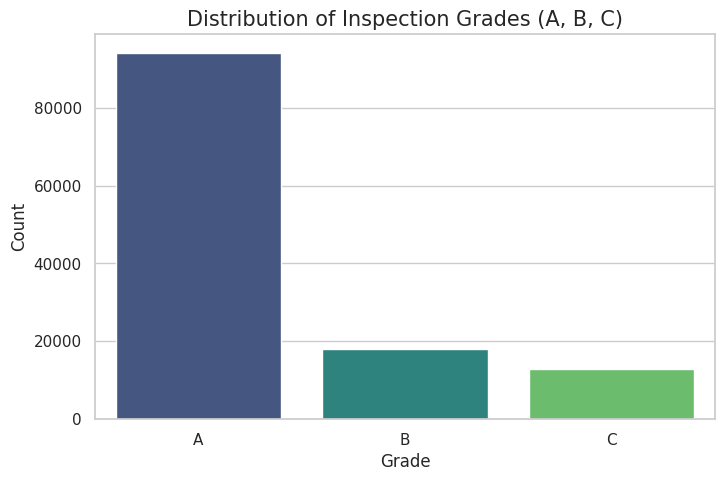

In [72]:
# Plot bar graph of inspection grade counts
plt.figure(figsize=(8, 5))

sns.countplot(x='grade', data=inspection_incident_df, order=['A', 'B', 'C'], palette='viridis')
plt.title('Distribution of Inspection Grades (A, B, C)', fontsize=15)
plt.xlabel('Grade')
plt.ylabel('Count')
plt.show()

This imbalance suggests that most NYC restaurants comply with health standards. However, for predictive modeling, this poses a challenge as models might become biased towards predicting the majority class ('A'). To address this, we will need to employ techniques such as SMOTE (Synthetic Minority Over-sampling Technique) or class weighting during the modeling phase to ensure our model can effectively identify the minority 'B' and 'C' grades, which are the primary targets for health interventions.

## 3.2: Grades by Borough

The breakdown of grades by borough reveals that Manhattan, followed by Queens and Brooklyn, have the highest volume of inspections. While 'A' grades are prevalent across all boroughs, there are noticeable counts of 'B' and 'C' grades in Manhattan and Queens, proportional to their higher restaurant density.

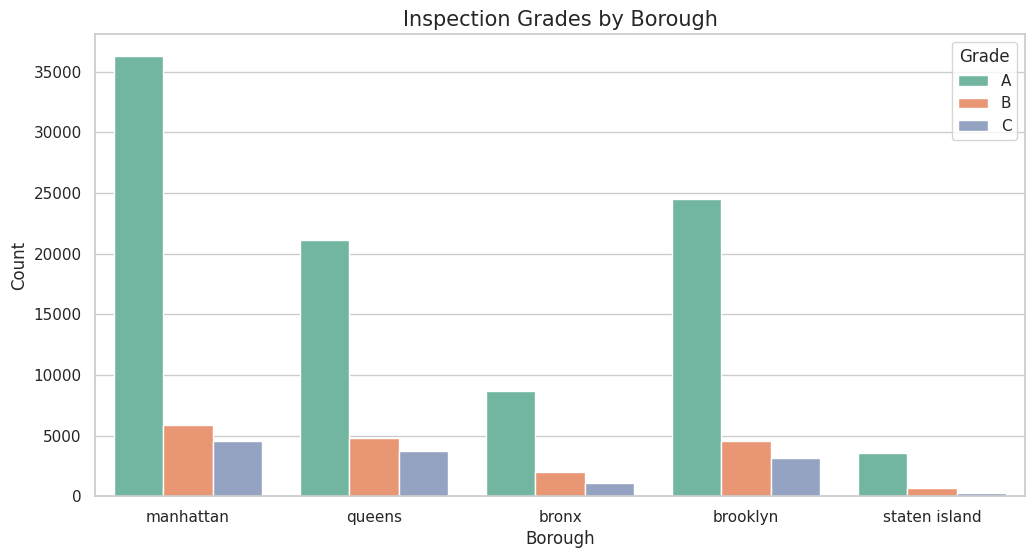

In [73]:
# Plot inspection grades grouped by borough
plt.figure(figsize=(12, 6))

sns.countplot(x='boro', hue='grade', data=inspection_incident_df, hue_order=['A', 'B', 'C'], palette='Set2')
plt.title('Inspection Grades by Borough', fontsize=15)
plt.xlabel('Borough')
plt.ylabel('Count')
plt.legend(title='Grade')
plt.show()

Geography plays a role in inspection volume but doesn't immediately show a drastic difference in proportions of bad grades just by looking at raw counts. However, the higher absolute number of non-A grades in Manhattan and Queens indicates these boroughs act as key hotspots for potential violations. Location features (like Borough or Zipcode) will likely be important predictors in our model.

## 3.3: Top 10 Cuisines

"American", "East/Southeast Asian", and "Pizza/Italian" are the most common cuisine types in the dataset. The distribution of inspections is heavily skewed towards these popular categories.

/tmp/ipython-input-523031831.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='cuisine_description', data=inspection_incident_df[inspection_incident_df['cuisine_description'].isin(top_cuisines)],


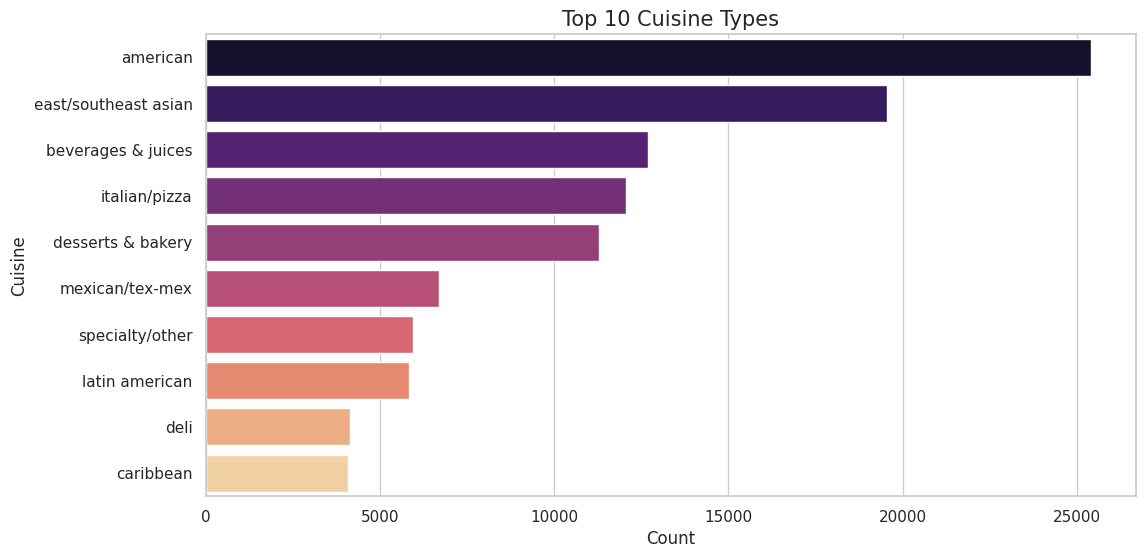

In [74]:
# Plot distribution of cuisine types
top_cuisines = inspection_incident_df['cuisine_description'].value_counts().head(10).index

plt.figure(figsize=(12, 6))
sns.countplot(y='cuisine_description', data=inspection_incident_df[inspection_incident_df['cuisine_description'].isin(top_cuisines)],
              order=top_cuisines, palette='magma')
plt.title('Top 10 Cuisine Types', fontsize=15)
plt.xlabel('Count')
plt.ylabel('Cuisine')
plt.show()

Certain cuisines might be overrepresented in the data. If specific cuisines have higher rates of violations (which we can investigate further with feature importance), the "Cuisine Description" will be a valuable categorical feature. We may need to group less common cuisines into an "Other" category to reduce noise and high dimensionality in our predictive model.

## 3.4: Score Distribution (Histogram)

The histogram of inspection scores is right-skewed. Most restaurants achieve low scores (which is good, as a lower score means fewer violations), clustering between 0 and 13 points (the threshold for an 'A' grade). There is a long tail extending to higher scores, representing restaurants with severe violations.

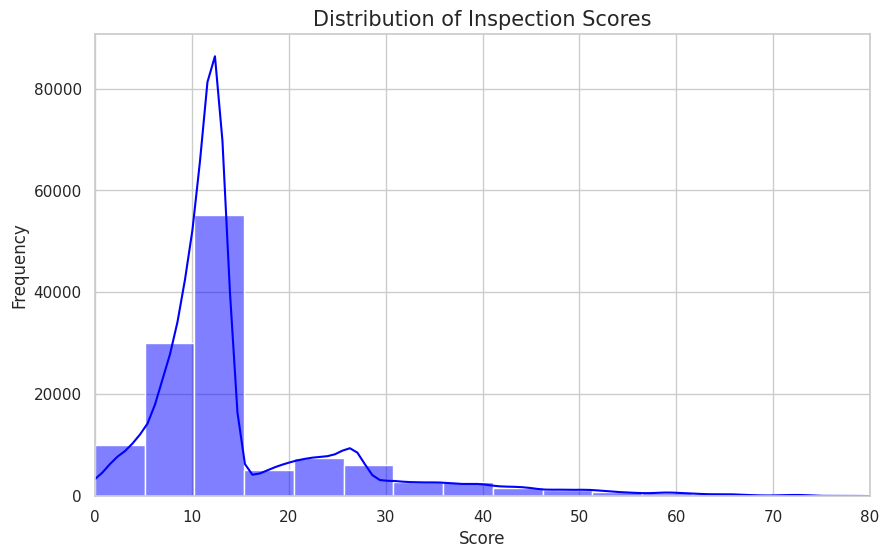

In [75]:
# Plot distribution of inspection scores
plt.figure(figsize=(10, 6))

sns.histplot(inspection_incident_df['score'], bins=30, kde=True, color='blue')
plt.title('Distribution of Inspection Scores', fontsize=15)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.xlim(0, 80)
plt.show()

The score distribution aligns with the grade distribution, confirming that most establishments are compliant. The "long tail" of high scores represents the critical minority of risky restaurants we aim to detect. Since 'Grade' is derived directly from 'Score', we must exclude 'Score' from our feature set to prevent data leakage. Instead, we will rely on features that predict this score, such as prior violation history and neighborhood characteristics.

## 3.5: Income vs. Health Grade

The boxplot indicates a subtle relationship between neighborhood income and inspection grades. Restaurants with 'A' grades tend to be located in census tracts with a slightly higher median income compared to those with 'B' and 'C' grades, although there is significant overlap.

/tmp/ipython-input-1641349343.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


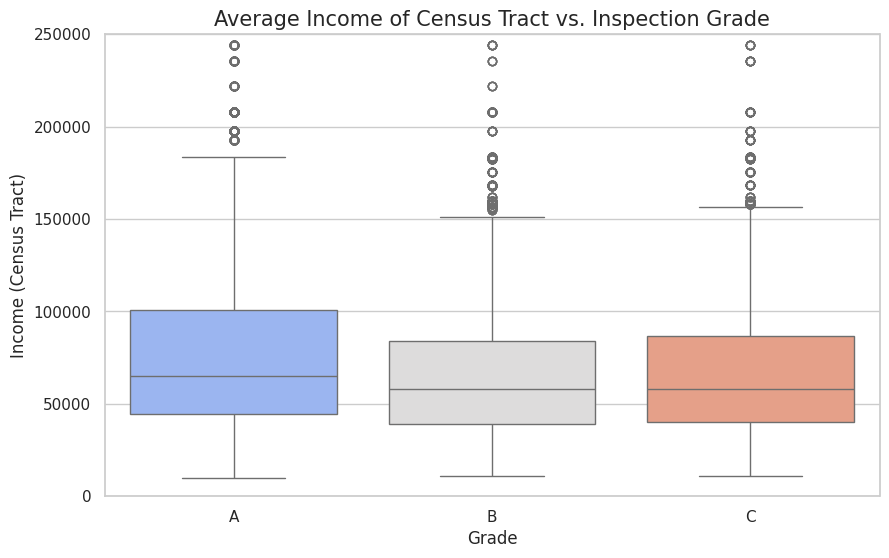

In [76]:
# Restaurants in higher-income census tracts are more likely to receive an A grade
# while those in lower-income areas show a higher proportion of B and C grades.

plot_data_income = inspection_incident_df.dropna(subset=['income', 'grade'])

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='grade',
    y='income',
    data=plot_data_income,
    order=['A', 'B', 'C'],
    palette='coolwarm'
)
plt.title('Average Income of Census Tract vs. Inspection Grade', fontsize=15)
plt.xlabel('Grade')
plt.ylabel('Income (Census Tract)') # Updated label
# Limit Y-axis to remove extreme outliers
plt.ylim(0, 250000)
plt.show()

Socioeconomic factors appear to have some influence on food safety compliance. Lower-income areas might face challenges such as older infrastructure or fewer resources for restaurant maintenance, potentially leading to lower grades. Including census-based economic features like Median Income in our model is justified and could help capture environmental risks associated with specific locations.

## 3.6: 311 Complaints vs. Health Score

The following scatter plot demonstrates a negligible correlation between total 311 complaint volume and health inspection scores at the zip code level. The data points exhibit wide dispersion with a near-zero slope in the trend line.

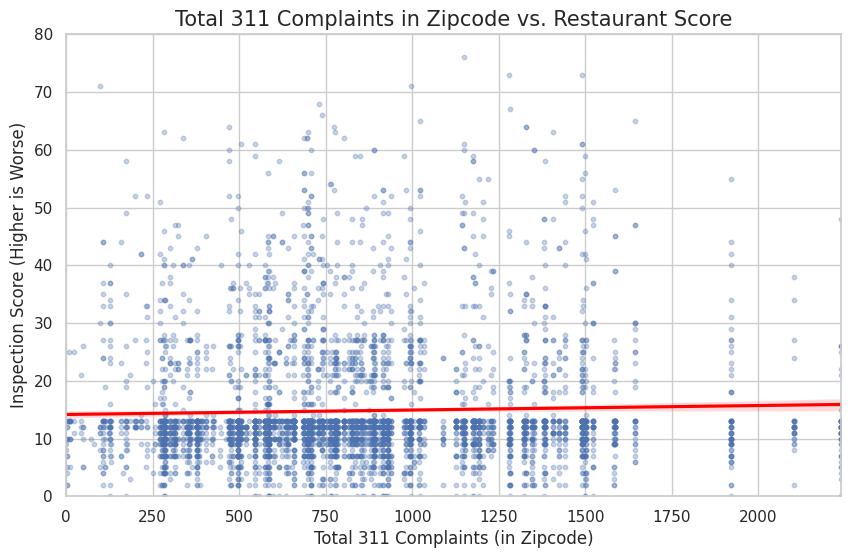

In [78]:
# Plot Total 311 Complaints vs. Health Score
# 311 complaints at the zipcode level do not strongly predict restaurant inspection performance.

# Drop rows where complaints or score is null
plot_data_complaints = inspection_incident_df.dropna(subset=['total_complaints', 'score'])

# Data has >120k points, which will be slow. Let's sample 5000 to see the trend.
if len(plot_data_complaints) > 5000:
    plot_data_complaints = plot_data_complaints.sample(5000, random_state=42)

plt.figure(figsize=(10, 6))
# regplot gives us a scatter plot plus a regression trend line
sns.regplot(
    x='total_complaints',
    y='score',
    data=plot_data_complaints,
    scatter_kws={'alpha':0.3, 's':10},
    line_kws={'color':'red'}
)
plt.title('Total 311 Complaints in Zipcode vs. Restaurant Score', fontsize=15)
plt.xlabel('Total 311 Complaints (in Zipcode)')
plt.ylabel('Inspection Score (Higher is Worse)')
# Limit axes to remove outliers and see the trend
plt.xlim(0, plot_data_complaints['total_complaints'].quantile(0.99))
plt.ylim(0, 80)
plt.show()

While we hypothesized that a "noisy" or "problematic" neighborhood (proxied by 311 complaints) might correlate with worse restaurant hygiene, the aggregate 311 count alone is not a strong linear predictor of individual restaurant scores. We may need to refine this feature, perhaps by calculating "complaints per capita" or focusing on specific complaint types (like "vermin" or "sanitation") rather than the total count, to extract a more meaningful signal for our model.

## 3.7: Restaurant Density vs. Health Score

The following scatter plot suggests a very slight trend where areas with higher restaurant density might see a wider variance in scores, but there is no strong linear relationship indicating that density causes worse scores.

Plotting Density vs. Score...


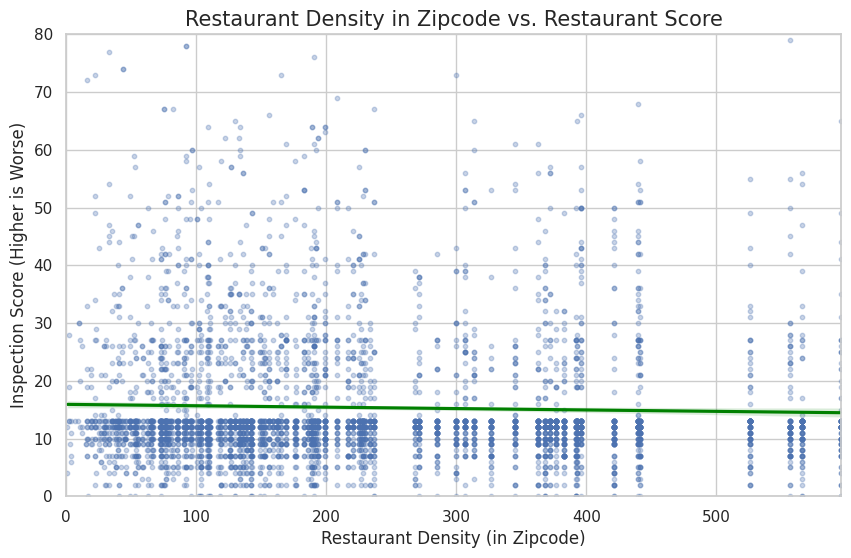

In [79]:
# Plot Restaurant Density vs. Health Score

print("Plotting Density vs. Score...")
# Drop rows where density or score is null
plot_data_density = inspection_incident_df.dropna(subset=['restaurant_density', 'score'])

# Also sample this one
if len(plot_data_density) > 5000:
    plot_data_density = plot_data_density.sample(5000, random_state=42)

plt.figure(figsize=(10, 6))
sns.regplot(
    x='restaurant_density',
    y='score',
    data=plot_data_density,
    scatter_kws={'alpha':0.3, 's':10},
    line_kws={'color':'green'}
)
plt.title('Restaurant Density in Zipcode vs. Restaurant Score', fontsize=15)
plt.xlabel('Restaurant Density (in Zipcode)')
plt.ylabel('Inspection Score (Higher is Worse)')
plt.xlim(0, plot_data_density['restaurant_density'].quantile(0.99))
plt.ylim(0, 80)
plt.show()

From this, we see that restaurant density alone is not a definitive predictor of failure. However, high-density areas (like Midtown Manhattan) imply higher competition and foot traffic, which could stress restaurant operations. We will retain this feature but likely interpret it in interaction with other variables (e.g., high density + low income) rather than as a standalone driver of risk.

## 3.8 Correlation Heatmap for Numeric Features

### 3.8.1: Engineer Numeric Features

Raw complaint counts (total_complaints) are naturally biased by population size as more people generate more calls. To create a fair comparison between neighborhoods, we engineer a normalized feature, complaints_per_capita, which represents the density of complaints relative to the local population.

In [80]:
# Complaint density: number of complaints per capita
inspection_incident_df["complaints_per_capita"] = (
    inspection_incident_df["total_complaints"] / inspection_incident_df["totalpop"]
)

In [81]:
# Basic sanity check
inspection_incident_df.head()

camis               dba       boro building            street  zipcode  \
0  50070543             CLARO  manhattan      284          3 AVENUE  10010.0   
1  41708524  REICHENBACH HALL  manhattan        5  WEST   37 STREET  10018.0   
2  41464542        SEVEN SINS  manhattan      293          3 AVENUE  10010.0   
3  41715927            GRUPPO  manhattan       98          AVENUE B  10009.0   
4  50144293     BLUE MOUNTAIN  manhattan      396          3 AVENUE  10016.0   

    cuisine_description inspection_date     action violation_code  ...  \
0       mexican/tex-mex      2022-09-23  violation            02B  ...   
1       specialty/other      2024-05-09  violation            09B  ...   
2              american      2024-12-12  violation            09B  ...   
3         italian/pizza      2023-11-16  violation            09B  ...   
4  east/southeast asian      2025-10-23  violation            09B  ...   

  total_inspections  restaurant_density totalpop    income incident_zip  \
0                 0                 217     7413  109526.0      10010.0   
1                 1                 368     2054  120938.0      10018.0   
2                 0                 217     8012   96090.0      10010.0   
3                 2                 271     7871   71033.0      10009.0   
4                 1                 372     7640  104272.0      10016.0   

   total_complaints  noise_complaint_count  vehicle_complaint_count  \
0             315.0                  145.0                    108.0   
1             284.0                  114.0                     95.0   
2             315.0                  145.0                    108.0   
3             781.0                  447.0                    229.0   
4             583.0                  290.0                    169.0   

  nuisance_complaint_count  complaints_per_capita  
0                     62.0               0.042493  
1                     75.0               0.138267  
2                     62.0               0.039316  
3                    105.0               0.099225  
4                    124.0               0.076309  

[5 rows x 30 columns]

 ### 3.8.2: Select Numeric Columns

 We select a subset of numeric features to inspect for multicollinearity. This list includes our target proxies (score if available, or implied risk via flag_sum), demographic factors (income, totalpop), and environmental stressors (restaurant_density, complaints). Grouping them allows us to check if any features are redundant before modeling.

In [82]:
# Identify the numeric columns

numeric_cols = [
    # Inspection-based features

    "flag_sum",

    # Geo / neighborhood identifiers (used as numeric in MI, though they are IDs)
    "zipcode",
    "census_tract",

    # Contextual features
    "restaurant_density",

    # Census socio-economic variables
    "totalpop",
    "income",

    # Complaint-related features
    "total_complaints",
    "noise_complaint_count",
    "vehicle_complaint_count",
    "nuisance_complaint_count",

    # Engineered features
    "complaints_per_capita",

]

numeric_df = inspection_incident_df[numeric_cols].head()


###  3.8.3: Compute Correlation Matrix and Plot

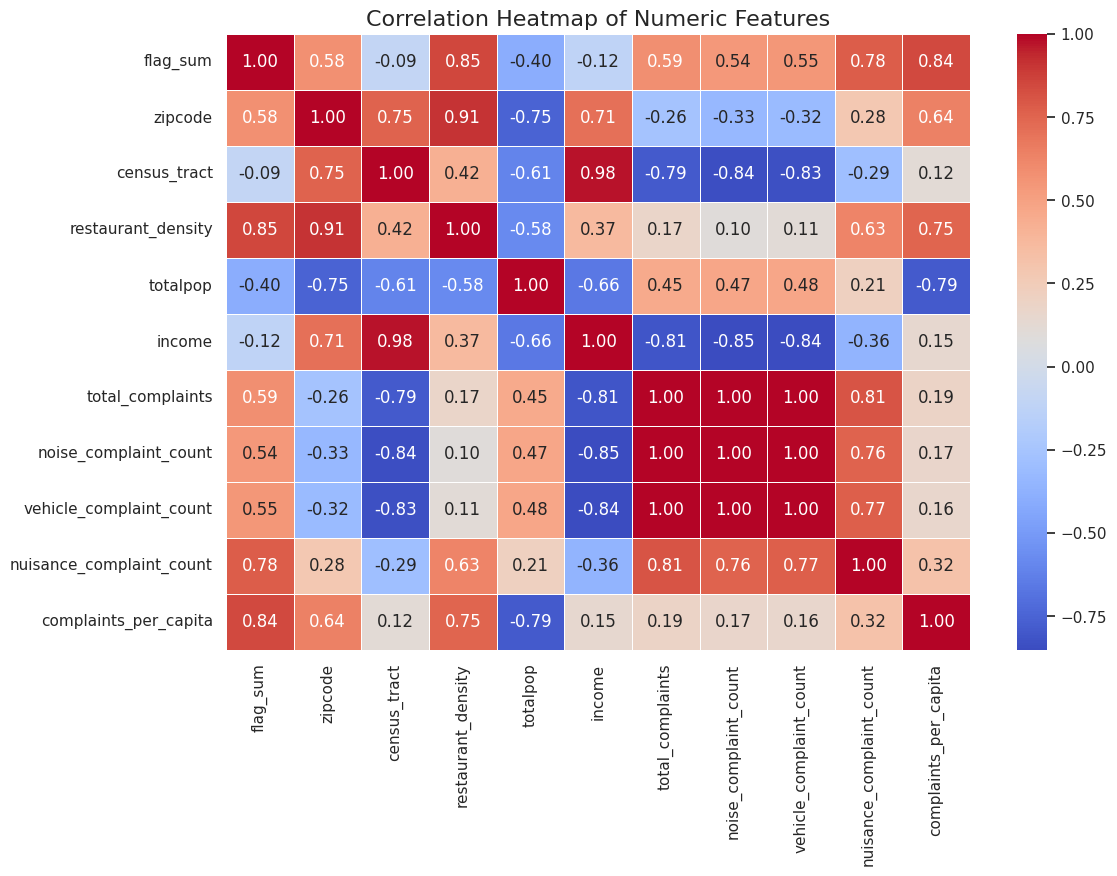

In [83]:
# Compute correlation matrix
corr_matrix = numeric_df.corr()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,          # show correlation values
    cmap='coolwarm',     # color map
    fmt=".2f",           # format to 2 decimals
    linewidths=0.5
)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.show()

Several strong correlation clusters emerge among the numeric variables. Census tract, income, and total population are highly correlated, reflecting shared socioeconomic context. Many complaint-related variables (total complaints, noise, vehicle, nuisance) form another tightly correlated group. Restaurant_density and zipcode also show strong associations with multiple variables. These patterns indicate that several features carry overlapping information, which is important to consider when interpreting feature importance or fitting linear models.

## 3.9: Geographic Heatmap of 'C' Grade Restaurants (Folium)

With limited resources, the city cannot inspect every restaurant every day. This heatmap solves that allocation challenge by turning abstract scores into actionable insights. It spotlights critical 'hotspots,' providing an easy to digest visual for identifying these areas with low inspection grades.

In [84]:
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium.plugins import HeatMap

df_final = inspection_incident_df.copy()

# Create ordered 'grade' category to ensure legends and axes are sorted logically (A, B, C).
df_final['grade'] = pd.Categorical(df_final['grade'], categories=['A', 'B', 'C'], ordered=True)

# For performance on large plots, create a smaller sample
df_sample = df_final.sample(n=15000, random_state=42) if len(df_final) > 15000 else df_final.copy()


print(df_final.columns)

Index(['camis', 'dba', 'boro', 'building', 'street', 'zipcode',
       'cuisine_description', 'inspection_date', 'action', 'violation_code',
       'violation_description', 'score', 'grade', 'grade_date', 'record_date',
       'latitude', 'longitude', 'census_tract', 'inspection_type_grouped',
       'flag_sum', 'total_inspections', 'restaurant_density', 'totalpop',
       'income', 'incident_zip', 'total_complaints', 'noise_complaint_count',
       'vehicle_complaint_count', 'nuisance_complaint_count',
       'complaints_per_capita'],
      dtype='object')


In [85]:
# Filter the data to include only restaurants with a 'C' grade
df_c_grades = df_final[df_final['grade'] == 'C'].copy()

# Drop any rows with missing latitude/longitude
df_c_grades.dropna(subset=['latitude', 'longitude'], inplace=True)

# Create a base map centered on NYC
nyc_center = [40.7128, -74.0060]
heatmap_map = folium.Map(location=nyc_center, zoom_start=11, tiles="CartoDB positron")

# Create a list of [lat, lon] for the HeatMap plugin
heat_data = df_c_grades[['latitude', 'longitude']].values.tolist()

# Add the HeatMap layer to the map
HeatMap(
    heat_data,
    radius=12,
    blur=15,
    gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
).add_to(heatmap_map)

# Add a title to the map using Folium's HTML capabilities
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Geographic Hotspots of 'C' Grade Restaurants</b></h3>
             '''
heatmap_map.get_root().html.add_child(folium.Element(title_html))

# Display the map
heatmap_map

By isolating 'C' grades, we uncover localized pockets of poor food safety compliance. This suggests that risk is spatially dependent, potentially due to local environmental factors (e.g., pests in a specific block) or regional enforcement differences. These spatial patterns justify the use of location-based features (like Zipcode or Borough) in our predictive model to capture these "neighborhood effects".

## 3.10: Interactive Parallel Categories Plot (Plotly)

The next area we explored was to see the connections between `boro`, `cuisine_grouped`, `action` and `grade` all at once, which was done using an interactive parallel categories plot.

In [86]:
# For readability, we will use the sampled data
# Ensure the categorical columns are of type 'category' or 'object'
df_parcats_sample = df_sample[['boro', 'cuisine_description', 'action', 'grade']].copy()
df_parcats_sample.dropna(inplace=True)

# Define the dimensions for the plot
dimensions = [
    go.parcats.Dimension(values=df_parcats_sample.boro, label='Borough'),
    go.parcats.Dimension(values=df_parcats_sample.cuisine_description, label='Cuisine Category'),
    go.parcats.Dimension(values=df_parcats_sample.action, label='Inspection Action'),
    go.parcats.Dimension(values=df_parcats_sample.grade, label='Final Grade', categoryorder='array', categoryarray=['A', 'B', 'C'])
]

# Create the color mapping based on the final grade
# We need to encode the 'grade' column to integers for the colorscale
color = pd.Categorical(df_parcats_sample['grade'], categories=['A', 'B', 'C'], ordered=True).codes
colorscale = [[0, 'green'], [0.5, 'orange'], [1, 'red']]

# Create the figure
fig_parcats = go.Figure(data=[
    go.Parcats(
        dimensions=dimensions,
        line={'color': color, 'colorscale': colorscale},
        hoveron='color',
        hoverinfo='count + probability',
        arrangement='freeform'
    )
])

fig_parcats.update_layout(
    title_text="<b>Flow of Restaurant Characteristics to Inspection Grade</b>",
    template="plotly_white",
    font=dict(family="Arial, sans-serif")
)

fig_parcats.show()

The Parallel Categories diagram visualizes the flow of categorical data from Borough -> Cuisine -> Action -> Grade. A critical observation is the deterministic relationship between specific "Actions" (e.g., "Establishment Closed by DOHMH") and the final "Grade" (flowing exclusively to B or C). We also see that certain cuisines have a visibly larger proportion of flows leading to non-A grades compared to others.

## 3.11: Faceted Scatter Plots: Income vs. Score by Borough (Plotly Express)

The next plot we explored was a facetted scatter plot to see how the relationship between neighborhood income and inspection score differ across boroughs.

In [87]:
df_facet_sample = df_sample.dropna(subset=['income', 'score', 'boro', 'grade'])

fig_facet = px.scatter(
    df_facet_sample,
    x="income",
    y="score",
    color="grade",
    facet_col="boro",  # Create a separate plot for each borough
    facet_col_wrap=3,  # Wrap after 3 columns
    category_orders={"grade": ["A", "B", "C"]},
    color_discrete_map={'A': 'green', 'B': 'orange', 'C': 'red'},
    trendline="ols",  # Add an Ordinary Least Squares regression line
    trendline_scope="overall", # A single trendline per facet
    labels={
        "income": "Median Household Income ($)",
        "score": "Inspection Score (Higher is Worse)"
    }
)

fig_facet.update_layout(
    title_text="<b>Inspection Score vs. Neighborhood Income, Faceted by Borough</b>",
    template="plotly_white"
)

# Set a reasonable y-axis limit to focus on the main data distribution
fig_facet.update_yaxes(range=[0, 80])

fig_facet.show()

The lack of a steep slope indicates that neighborhood income is not a simple linear predictor of restaurant safety; a rich neighborhood doesn't guarantee a clean restaurant. This suggests that linear models (like Logistic Regression) might struggle to leverage this feature effectively. Instead, tree-based models (like Random Forest) will be better suited to capture the non-linear thresholds where income might interact with other factors (like density) to impact risk.

## 3.12: 3D Scatter Plot: Score vs. Income vs. Complaints (Plotly)

This next plot allows us to explore whether there's a combined effect of socio-economic status (income) and neighborhood issues (total_complaints) on the inspection score.

In [88]:
df_3d_sample = df_sample.dropna(subset=['income', 'total_complaints', 'score', 'grade'])

fig_3d = px.scatter_3d(
    df_3d_sample,
    x='income',
    y='total_complaints',
    z='score',
    color='grade',
    color_discrete_map={'A': 'green', 'B': 'orange', 'C': 'red'},
    category_orders={"grade": ["A", "B", "C"]},
    opacity=0.7,
    labels={
        "income": "Median Income ($)",
        "total_complaints": "Total 311 Complaints (in Zipcode)",
        "score": "Inspection Score"
    },
    title="<b>3D View: Score vs. Income and 311 Complaints</b>"
)

fig_3d.update_layout(
    template="plotly_white",
    margin=dict(l=0, r=0, b=0, t=40)
)

# Set a reasonable z-axis limit
fig_3d.update_traces(marker=dict(size=3))
fig_3d.update_scenes(zaxis=dict(range=[0, 80]))

fig_3d.show()

This visualizes the complexity of the classification boundary. Since the "bad" restaurants are scattered in this 3D space rather than linearly separable, it confirms that simple heuristics (e.g., "poor areas have dirty restaurants") are insufficient. This justifies our project's goal of using advanced machine learning techniques to learn these complex, high-dimensional decision boundaries that human intuition and plots cannot easily define.

#Part 4: Feature Engineering & Preprocessing

In this section, we turn raw inspection and neighborhood data into a
clean, learning-ready representation.

In [89]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

## 4.1: Date Feature Engineering

Inspection dates are more than just timestamps. They may encode:

- **Seasonality**: certain months may be associated with higher violation rates
  (e.g., heat and food spoilage in summer).
- **Weekday effects**: weekday vs. weekend operations may differ.

We therefore decompose the inspection date into **year, month, and weekday**
to let the models capture these temporal patterns.

In [90]:
# Add date features ('year', 'month', 'weekday')
if 'year' not in inspection_incident_df.columns:
    inspection_incident_df['inspection_date'] = pd.to_datetime(inspection_incident_df['inspection_date'])
    inspection_incident_df['year'] = inspection_incident_df['inspection_date'].dt.year
    inspection_incident_df['month'] = inspection_incident_df['inspection_date'].dt.month
    inspection_incident_df['weekday'] = inspection_incident_df['inspection_date'].dt.weekday

In [91]:
inspection_incident_df[['year', 'month', 'weekday']].head()

year  month  weekday
0  2022      9        4
1  2024      5        3
2  2024     12        3
3  2023     11        3
4  2025     10        3

## 4.2: Cuisine Feature Engineering

The raw `cuisine_description` column contains a long tail of rare cuisines.
Many of these categories appear only a few times, which makes it difficult
for the model to learn stable patterns

In [92]:
# Keep the 20 most common cuisines, group the rest into "Other".
top_20_cuisines = inspection_incident_df['cuisine_description'].value_counts().head(20).index
inspection_incident_df['cuisine_grouped'] = inspection_incident_df['cuisine_description'].apply(
    lambda x: x if x in top_20_cuisines else 'Other'
)

In [93]:
# Inspect the distribution of the grouped cuisine categories
inspection_incident_df['cuisine_grouped'].value_counts().head()

cuisine_grouped
american                25424
east/southeast asian    19545
beverages & juices      12689
italian/pizza           12064
desserts & bakery       11295
Name: count, dtype: int64

## 4.3: Define Final Features (X) and Target (y)
Next, we identify which columns will serve as **predictors (X)** and which
column will serve as the **target (y)** for our classification task.

In [94]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

### 4.3.1 Select Numeric and Categorical Feature Columns

We focus on two families of predictors:

- **Numeric features (`numeric_cols`)**  
  e.g., `flag_sum`, `income`, `totalpop`, `complaints_per_capita`,
  `census_tract` and other engineered numeric variables.

- **Categorical features (`categorical_features`)**  
  - `boro` – borough-level location information  
  - `cuisine_grouped` – cuisine type with rare categories grouped into `"Other"`

We first clean and evaluate numeric features using Mutual Information, then
combine them with these two categorical variables to build our final feature set.

In [95]:
#  Numeric feature cleaning
X_num = inspection_incident_df[numeric_cols].copy()
X_num = X_num.replace([np.inf, -np.inf], np.nan)
X_num = X_num.fillna(X_num.median())

### 4.3.2: Compute Mutual Information for Numeric Features

To understand which numeric features carry the most signal about the final grade,
we compute Mutual Information (MI) between each numeric feature and the
encoded grade labels.

- MI captures any kind of dependency (not just linear).
- Higher MI indicates that knowing this feature reduces uncertainty about the grade.

In [96]:
# Encode target label (grade)
le = LabelEncoder()
y_enc = le.fit_transform(inspection_incident_df["grade"])

# Compute MI scores for numeric features
mi = mutual_info_classif(X_num, y_enc, random_state=42)
mi_series = pd.Series(mi, index=numeric_cols).sort_values(ascending=False)

print("MI scores for numeric features (sorted):")
display(mi_series)

MI scores for numeric features (sorted):


complaints_per_capita       0.095825
income                      0.080523
totalpop                    0.073904
census_tract                0.054136
zipcode                     0.020014
total_complaints            0.017737
vehicle_complaint_count     0.016204
noise_complaint_count       0.015245
restaurant_density          0.014578
nuisance_complaint_count    0.010072
flag_sum                    0.008288
dtype: float64

We examined the mutual information (MI) scores in descending order and selected the top K features at the natural elbow point of the MI curve.

The top five features form a distinct tier: their MI values range from ~0.10 to ~0.02, after which the MI drops further into the 0.01 range. Features below 0.02 contribute noticeably less information, indicating diminishing predictive value.

Therefore, we set K = 5 as the cutoff, capturing all high-signal features while excluding low-MI predictors that contribute noise or redundancy. This yields a compact and interpretable feature subset.

### 4.3.3: Select Top K Numeric Features

Based on the MI curve and the elbow point, we select the top `K` numeric features
to include in our model. This keeps the feature space compact and focused on
the most informative signals.

In [97]:
# Choose top K numeric features (K can be tuned: 4, 5, or 6)
K = min(5, len(mi_series))
numeric_features = mi_series.head(K).index.tolist()

print(f"\nFinal selected {len(numeric_features)} numeric_features:")
print(numeric_features)


Final selected 5 numeric_features:
['complaints_per_capita', 'income', 'totalpop', 'census_tract', 'zipcode']


In [98]:
# Define categorical features
categorical_features = ["boro", "cuisine_grouped"]

### 4.3.4: Construct X (features) and y (target)

We now assemble our modeling dataset:

- **X**: top K numeric features + selected categorical variables.
- **y**: inspection `grade` (A, B, C).

This is the core table that will be passed through preprocessing pipelines
and then fed into our models.

In [99]:
#  Build the feature matrix (X) and target vector (y)
X = inspection_incident_df[numeric_features + categorical_features].copy()
y = inspection_incident_df['grade'].copy()  # A/B/C target

### 4.3.5: Summary of Feature Selection Strategy

Our feature selection is guided by two principles:

1. **Avoid data leakage**  
   We deliberately exclude the raw inspection score as a predictor when
   modeling the grade, because the grade is derived almost deterministically
   from the score. Including it would make the prediction task trivial and
   unrealistic.

2. **Prioritize interpretability and stability**  
   For numeric predictors, we computed **Mutual Information (MI)** with the grade,
   ranked the features, and selected the top K = 5:

   - `complaints_per_capita`  
   - `income`  
   - `totalpop`   
   - `census_tract`
   - `zipcode`

This yields a compact, interpretable set of numeric features that carry
meaningful signal about inspection grades without leaking the label.

### 4.3.6: Inspect Shape Before Cleaning Missing Values

Before we drop any rows, we check the size of `X` and `y`. This provides a
baseline for how many observations we might lose during the cleaning step.

In [100]:
#  Check shapes before removing missing values
print(f"Shape of X before dropping NaNs: {X.shape}")
print(f"Shape of y before dropping NaNs: {y.shape}")

Shape of X before dropping NaNs: (124866, 7)
Shape of y before dropping NaNs: (124866,)


### 4.3.7: Remove Rows With Missing Values in Either X or y

To avoid subtle bugs and complications during modeling, we drop rows that have
missing values in either the features or the target. This ensures that all
downstream models see a clean, fully-observed dataset.

In [101]:
# Drop rows with missing values in either X or y
temp_df = X.copy()
temp_df['__TARGET__'] = y

temp_df.dropna(inplace=True)

# Recover cleaned X and y
y = temp_df['__TARGET__']
X = temp_df.drop(columns=['__TARGET__'])

print(" NaNs Removed from both X and y ")
print(f"Shape of X after dropping NaNs: {X.shape}")
print(f"Shape of y after dropping NaNs: {y.shape}")

 NaNs Removed from both X and y 
Shape of X after dropping NaNs: (121990, 7)
Shape of y after dropping NaNs: (121990,)


In [102]:
# Final check on the cleaned feature matrix
X.head()

complaints_per_capita    income  totalpop  census_tract  zipcode  \
0               0.042493  109526.0      7413        6800.0  10010.0   
1               0.138267  120938.0      2054        8400.0  10018.0   
2               0.039316   96090.0      8012        6400.0  10010.0   
3               0.099225   71033.0      7871        3200.0  10009.0   
4               0.076309  104272.0      7640        7200.0  10016.0   

        boro       cuisine_grouped  
0  manhattan       mexican/tex-mex  
1  manhattan       specialty/other  
2  manhattan              american  
3  manhattan         italian/pizza  
4  manhattan  east/southeast asian

## 4.4: Train–Test Split

To evaluate our models honestly, we hold out a portion of the data as a
**test set** that is never seen during training or model selection.

We use a **stratified split** so that the distribution of grades (A/B/C)
is similar in both the training and test sets.

In [103]:
from sklearn.model_selection import train_test_split

#  Train–test split with stratification on grade
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # preserve grade distribution across splits
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (97592, 7)
Testing set shape: (24398, 7)


## 4.5: Create Preprocessing Pipeline

Different models expect input features in a consistent numeric format.  
To handle this cleanly, we build a scikit-learn `ColumnTransformer` pipeline that:

1. **Standardizes numeric features** (so they are on a comparable scale).
2. **One-hot encodes categorical features** (`boro`, `cuisine_grouped`).

The result is a single, model-ready feature matrix that we can reuse across
all classifiers in Part 5.

### 4.5.1: Standardize Numeric Features

Some models (e.g., logistic regression, neural networks) are sensitive to
feature scale. We therefore apply **`StandardScaler`** to:

- Center each numeric feature around 0.
- Scale it to unit variance.

Tree-based models do not strictly require scaling, but using a consistent
preprocessing pipeline simplifies comparisons across model families.

In [104]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
# Numeric Transformer: StandardScaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

### 4.5.2: One-Hot Encode Categorical Features

For our categorical predictors (`boro`, `cuisine_grouped`), we use
**one-hot encoding**:

- Creates a binary column for each category.
- Allows linear models to assign separate weights to each category.
- `handle_unknown='ignore'` ensures robustness to rare or unseen categories
  in the test set.

In [105]:
# Categorical Transformer: OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

### 4.5.3: Combine Numeric and Categorical Transformers

We now combine the numeric and categorical pipelines into a single
`ColumnTransformer`. This object will:

- Apply scaling to the numeric features.
- Apply one-hot encoding to the categorical features.
- Concatenate the results into a unified feature matrix.

In [106]:
# Column Transformer: combine both transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## 4.6: Apply Preprocessing

We now fit the preprocessing pipeline on the **training data** and apply
the learned transformations to both the training and test sets.

This ensures that:

- Scaling parameters are estimated only from the training data.
- The test set is treated as truly “unseen” data.

In [107]:
#  Fit preprocessing on training data, transform both splits
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed X_train shape:", X_train_processed.shape)
print("Processed X_test shape:", X_test_processed.shape)

Processed X_train shape: (97592, 31)
Processed X_test shape: (24398, 31)


## 4.7: Encode Target Variable (y)

Most scikit-learn classifiers expect the target to be numeric.  
We therefore use a `LabelEncoder` to map:

- `'A'`, `'B'`, `'C'` → integer labels (e.g., 0, 1, 2).

We keep track of the mapping so we can interpret predictions later.

In [108]:
#  Encode grade labels as integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("Label Encoder Classes:", le.classes_)
print("Example encoded y_train:", y_train_encoded[:10])

Label Encoder Classes: ['A' 'B' 'C']
Example encoded y_train: [0 2 0 0 0 0 1 0 2 0]


## 4.8: Apply SMOTE to Handle Class Imbalance

Inspection grades are **not** evenly distributed as there are many more
`A` grades than `C` grades.

To give the model a fair chance to learn patterns associated with low-performing
restaurants, we apply **SMOTE (Synthetic Minority Over-sampling Technique)** on
the training set only:

- Generates synthetic minority examples in feature space.
- Balances the class distribution seen during training.
- Leaves the test set untouched so evaluation remains realistic.

In [109]:
from imblearn.over_sampling import SMOTE
import pandas as pd

print("Class distribution BEFORE SMOTE:")
print(pd.Series(y_train_encoded).value_counts())

#  Apply SMOTE only on the training data
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_processed, y_train_encoded)

print("\nShapes:")
print("  X_train_processed:", X_train_processed.shape)
print("  X_train_resampled:", X_train_resampled.shape)

print("\nClass distribution AFTER SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Class distribution BEFORE SMOTE:
0    73389
1    14151
2    10052
Name: count, dtype: int64

Shapes:
  X_train_processed: (97592, 31)
  X_train_resampled: (220167, 31)

Class distribution AFTER SMOTE:
0    73389
2    73389
1    73389
Name: count, dtype: int64


# Part 5: Modeling

With a clean, balanced, and fully preprocessed dataset in hand,
we now turn to the core question:

> **Can we predict which restaurants are at higher sanitation risk,
>  as reflected in their inspection grades?**

We proceed in stages:

1. Start with a **baseline logistic regression**.
2. Move to more flexible **tree-based models** (Random Forest, XGBoost).
3. Explore a simple **neural network**.
4. Compare models using metrics that emphasize **recall for low-performing
   (Grade C) restaurants**, since missing risky establishments is costly.



In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 5.1: Model 1 – Baseline Logistic Regression

We begin with a **multinomial Logistic Regression** model:

- It is simple, fast, and interpretable.
- It provides a strong baseline for comparison.
- It works naturally with our standardized and one-hot encoded features.

If more complex models cannot substantially outperform logistic regression,
that is a strong signal that the problem is either inherently noisy or
that our features need further refinement.

### 5.1.1: Logistic Regression

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score

print(" Training Baseline Model (Logistic Regression) ")

# Initialize Model
log_reg = LogisticRegression(
    class_weight=None,
    random_state=42,
    max_iter=1000
)

# Train
log_reg.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_lr = log_reg.predict(X_test_processed)

#  Evaluate (Priority Order: Recall -> F1 -> Accuracy)
# 1. Calculate Core Metrics
recalls = recall_score(y_test_encoded, y_pred_lr, average=None)
class_c_recall = recalls[2]  # Class C (Risk) Recall
macro_f1 = f1_score(y_test_encoded, y_pred_lr, average='macro')
acc = accuracy_score(y_test_encoded, y_pred_lr)

# 2. Print Metrics in Priority Order
print(f"\n Key Metrics Summary:")
print(f"1. Class C Recall (Risk): {class_c_recall:.2%}  <-- Most Important")
print(f"2. Macro F1 Score:        {macro_f1:.4f}")
print(f"3. Overall Accuracy:      {acc:.4f}")

# 3. Print Complete Classification Report
print("\nClassification Report (Baseline):")
print(classification_report(y_test_encoded, y_pred_lr, target_names=['A', 'B', 'C']))

 Training Baseline Model (Logistic Regression) 

 Key Metrics Summary:
1. Class C Recall (Risk): 43.77%  <-- Most Important
2. Macro F1 Score:        0.3746
3. Overall Accuracy:      0.5204

Classification Report (Baseline):
              precision    recall  f1-score   support

           A       0.82      0.59      0.68     18347
           B       0.19      0.23      0.21      3538
           C       0.16      0.44      0.23      2513

    accuracy                           0.52     24398
   macro avg       0.39      0.42      0.37     24398
weighted avg       0.66      0.52      0.57     24398



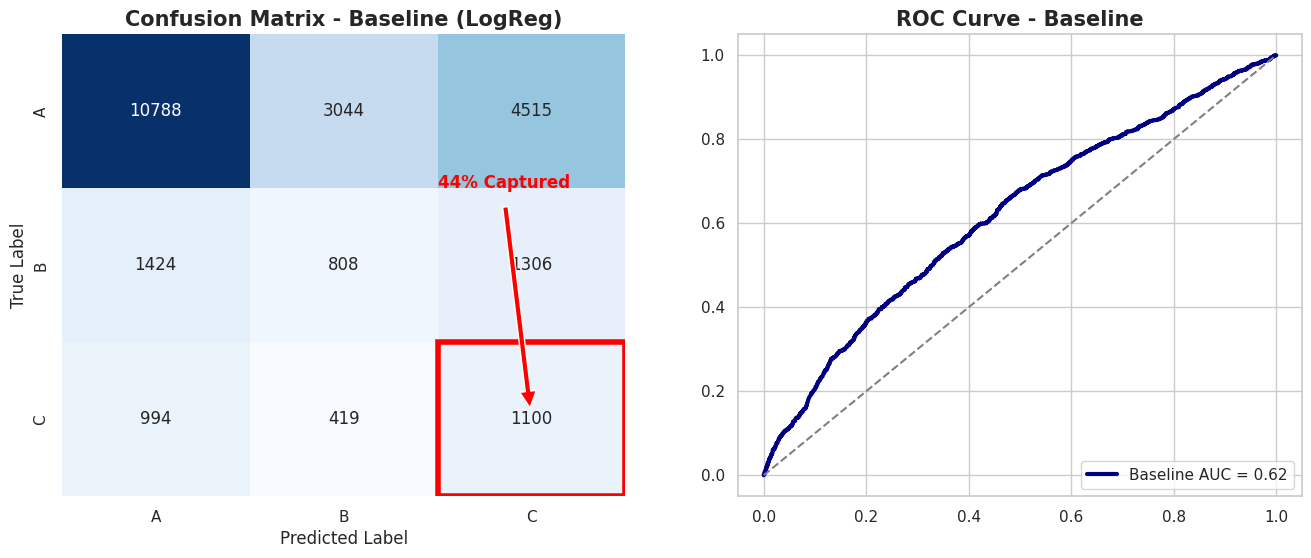

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.patches as patches
import numpy as np

#  Data Prep
cm = confusion_matrix(y_test_encoded, y_pred_lr)
y_prob = log_reg.predict_proba(X_test_processed)
class_c_index = 2

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

#  Chart 1: Confusion Matrix (Blue)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['A', 'B', 'C'], yticklabels=['A', 'B', 'C'], ax=ax[0], annot_kws={"size": 12})
ax[0].set_title('Confusion Matrix - Baseline (LogReg)', fontsize=15, fontweight='bold')
ax[0].set_xlabel('Predicted Label'); ax[0].set_ylabel('True Label')

# Highlight & Annotate
rect = patches.Rectangle((2, 2), 1, 1, linewidth=4, edgecolor='red', facecolor='none')
ax[0].add_patch(rect)
recall = cm[2,2] / cm[2,:].sum()
ax[0].annotate(f"{recall:.0%} Captured", xy=(2.5, 2.5), xytext=(2, 1), color='red', fontweight='bold', arrowprops=dict(facecolor='red', shrink=0.05))

#  Chart 2: ROC Curve
y_test_bin = (y_test_encoded == class_c_index).astype(int)
fpr, tpr, _ = roc_curve(y_test_bin, y_prob[:, class_c_index])
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, color='navy', lw=3, label=f'Baseline AUC = {roc_auc:.2f}')
ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
ax[1].set_title('ROC Curve - Baseline', fontsize=15, fontweight='bold')
ax[1].legend(loc="lower right")
plt.show()

### 5.1.2: Regularized Logistic Regression (L1)

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score

print(" Training Regularized Logistic Regression (L1) ")

# L1-regularized Logistic Regression (sparse & more feature-selection-like)
log_reg_l1 = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=1.0,
    max_iter=1000,
    random_state=42
)

# Train
log_reg_l1.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_lr_l1 = log_reg_l1.predict(X_test_processed)

#  Evaluate (Priority: Recall C -> Macro F1 -> Accuracy)
recalls_l1 = recall_score(y_test_encoded, y_pred_lr_l1, average=None)
class_c_recall_l1 = recalls_l1[2]
macro_f1_l1 = f1_score(y_test_encoded, y_pred_lr_l1, average='macro')
acc_l1 = accuracy_score(y_test_encoded, y_pred_lr_l1)

print("\n Key Metrics Summary (L1 Logistic Regression):")
print(f"1. Class C Recall (Risk): {class_c_recall_l1:.2%}")
print(f"2. Macro F1 Score:        {macro_f1_l1:.4f}")
print(f"3. Overall Accuracy:      {acc_l1:.4f}")

print("\nClassification Report (L1 Logistic Regression):")
print(classification_report(y_test_encoded, y_pred_lr_l1, target_names=['A', 'B', 'C']))

import numpy as np
num_zero = np.sum(log_reg_l1.coef_ == 0)
num_total = log_reg_l1.coef_.size
print(f"\nZero coefficients: {num_zero}/{num_total} ({num_zero/num_total:.2%})")

 Training Regularized Logistic Regression (L1) 

 Key Metrics Summary (L1 Logistic Regression):
1. Class C Recall (Risk): 43.97%
2. Macro F1 Score:        0.3741
3. Overall Accuracy:      0.5200

Classification Report (L1 Logistic Regression):
              precision    recall  f1-score   support

           A       0.82      0.59      0.68     18347
           B       0.19      0.23      0.21      3538
           C       0.16      0.44      0.23      2513

    accuracy                           0.52     24398
   macro avg       0.39      0.42      0.37     24398
weighted avg       0.66      0.52      0.57     24398


Zero coefficients: 4/93 (4.30%)


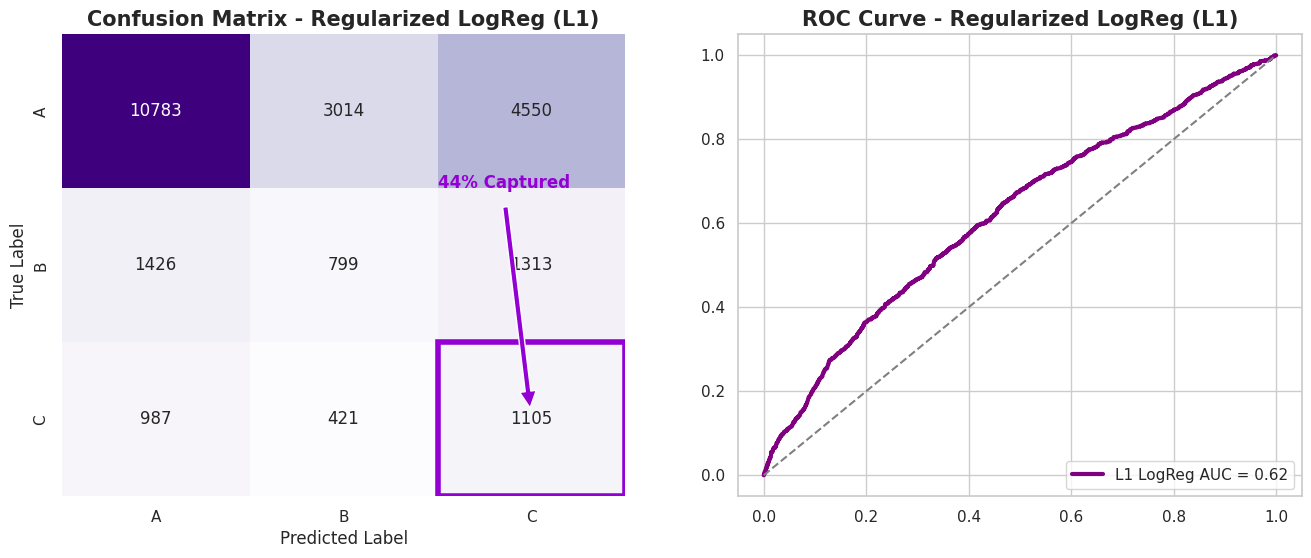

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.patches as patches
import numpy as np

#  Data Prep for Section 5.1.2 (L1 Regularized)
cm = confusion_matrix(y_test_encoded, y_pred_lr_l1)
y_prob = log_reg_l1.predict_proba(X_test_processed)
class_c_index = 2

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

#  Chart 1: Confusion Matrix (Purple)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['A', 'B', 'C'], yticklabels=['A', 'B', 'C'], ax=ax[0], annot_kws={"size": 12})
ax[0].set_title('Confusion Matrix - Regularized LogReg (L1)', fontsize=15, fontweight='bold')
ax[0].set_xlabel('Predicted Label'); ax[0].set_ylabel('True Label')

# Highlight & Annotate (Class C Recall)
rect = patches.Rectangle((2, 2), 1, 1, linewidth=4, edgecolor='darkviolet', facecolor='none')
ax[0].add_patch(rect)
recall = cm[2,2] / cm[2,:].sum()
ax[0].annotate(f"{recall:.0%} Captured", xy=(2.5, 2.5), xytext=(2, 1),
               color='darkviolet', fontweight='bold', arrowprops=dict(facecolor='darkviolet', shrink=0.05))

#  Chart 2: ROC Curve
y_test_bin = (y_test_encoded == class_c_index).astype(int)
fpr, tpr, _ = roc_curve(y_test_bin, y_prob[:, class_c_index])
roc_auc = auc(fpr, tpr)

ax[1].plot(fpr, tpr, color='purple', lw=3, label=f'L1 LogReg AUC = {roc_auc:.2f}')
ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
ax[1].set_title('ROC Curve - Regularized LogReg (L1)', fontsize=15, fontweight='bold')
ax[1].legend(loc="lower right")

plt.show()

We observe that the L1-regularized logistic regression produces almost identical predictive performance compared to the baseline logistic regression. This is expected because (1) our encoded features exhibit relatively low multicollinearity, limiting the amount of meaningful coefficient shrinkage L1 can perform, and (2) logistic regression is fundamentally limited in capturing the nonlinear interactions present in the dataset. As a result, L1 regularization mainly contributes sparsity and interpretability rather than performance gains.

### Baseline Model Commentary: Logistic Regression gives us:

- A **solid baseline** that already captures meaningful structure in the data.
- Clear interpretability, which helps validate that our feature engineering
  aligns with domain expectations.

However, the limited recall for Grade C motivates us to explore more flexible,
nonlinear models next.

## 5.2: Model 2 – Random Forest Classifier

To capture nonlinear interactions and complex decision boundaries,
we move to a **Random Forest** classifier:

- Ensembles many decision trees built on bootstrap samples.
- Naturally handles mixed feature types (after preprocessing).
- Provides robust estimates of feature importance.

We first train a baseline Random Forest with reasonable defaults,
then later tune its hyperparameters.

### 5.2.1: Baseline Random Forest

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score

print(" Training Random Forest ")

# Initialize Model
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,

    n_jobs=-1  # Use all available CPU cores
)

# Train
rf.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_rf = rf.predict(X_test_processed)

#  Evaluate (Priority Order: Recall -> F1 -> Accuracy)
# 1. Calculate Core Metrics
recalls = recall_score(y_test_encoded, y_pred_rf, average=None)
class_c_recall = recalls[2]  # Class C (Risk) Recall
macro_f1 = f1_score(y_test_encoded, y_pred_rf, average='macro')
acc = accuracy_score(y_test_encoded, y_pred_rf)

# 2. Print Metrics in Priority Order
print(f"\n Key Metrics Summary (Random Forest):")
print(f"1. Class C Recall (Risk): {class_c_recall:.2%}  <-- Most Important")
print(f"2. Macro F1 Score:        {macro_f1:.4f}")
print(f"3. Overall Accuracy:      {acc:.4f}")

# 3. Print Complete Classification Report
print("\nClassification Report (Random Forest):")
print(classification_report(y_test_encoded, y_pred_rf, target_names=['A', 'B', 'C']))

 Training Random Forest 

 Key Metrics Summary (Random Forest):
1. Class C Recall (Risk): 80.54%  <-- Most Important
2. Macro F1 Score:        0.5878
3. Overall Accuracy:      0.6845

Classification Report (Random Forest):
              precision    recall  f1-score   support

           A       0.93      0.69      0.79     18347
           B       0.39      0.59      0.46      3538
           C       0.37      0.81      0.51      2513

    accuracy                           0.68     24398
   macro avg       0.56      0.69      0.59     24398
weighted avg       0.79      0.68      0.71     24398



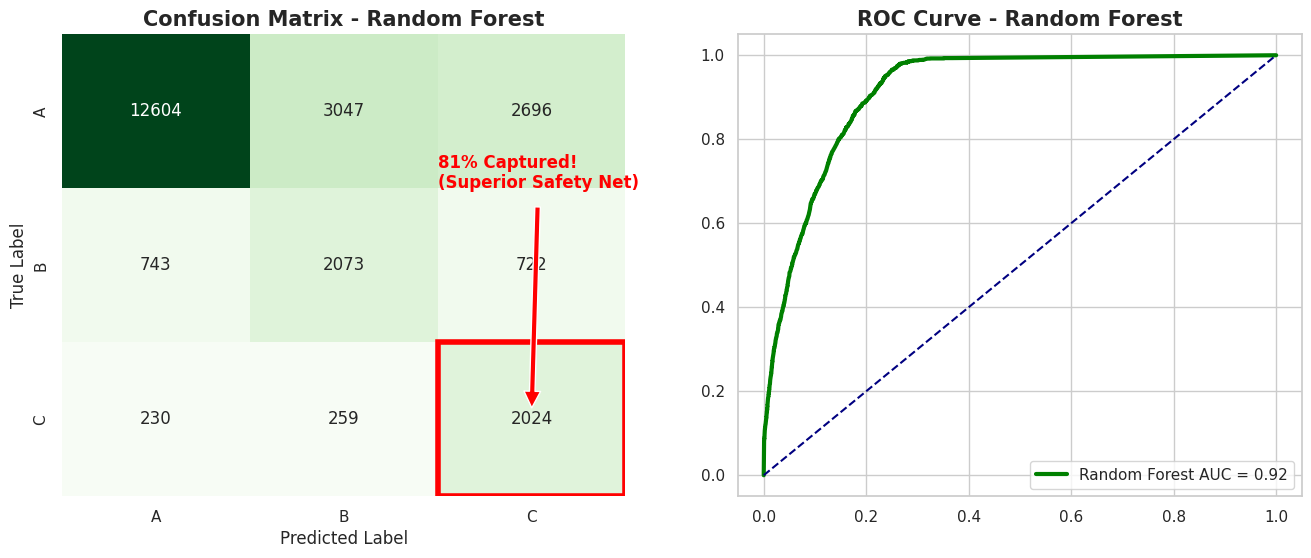

In [116]:
#  Data Prep
cm = confusion_matrix(y_test_encoded, y_pred_rf)
y_prob = rf.predict_proba(X_test_processed)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

#  Chart 1: Confusion Matrix (Green)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['A', 'B', 'C'], yticklabels=['A', 'B', 'C'], ax=ax[0], annot_kws={"size": 12})
ax[0].set_title('Confusion Matrix - Random Forest', fontsize=15, fontweight='bold')
ax[0].set_xlabel('Predicted Label'); ax[0].set_ylabel('True Label')

# Highlight
rect = patches.Rectangle((2, 2), 1, 1, linewidth=4, edgecolor='red', facecolor='none')
ax[0].add_patch(rect)
recall = cm[2,2] / cm[2,:].sum()
ax[0].annotate(f"{recall:.0%} Captured!\n(Superior Safety Net)", xy=(2.5, 2.5), xytext=(2, 1), color='red', fontweight='bold', fontsize=12, arrowprops=dict(facecolor='red', shrink=0.05))

#  Chart 2: ROC Curve
y_test_bin = (y_test_encoded == class_c_index).astype(int)
fpr, tpr, _ = roc_curve(y_test_bin, y_prob[:, class_c_index])
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, color='green', lw=3, label=f'Random Forest AUC = {roc_auc:.2f}')
ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
ax[1].set_title('ROC Curve - Random Forest', fontsize=15, fontweight='bold')
ax[1].legend(loc="lower right")
plt.show()

This is the standout model of our study. The Random Forest classifier significantly outperforms all other models, achieving the highest Accuracy (68%) and, most importantly, a remarkable Recall of 81% for Class C.

### 5.2.2: Tuning Random Forest Hyperparameters

The performance of a Random Forest depends heavily on hyperparameters such as:

- `n_estimators` (number of trees),
- `max_depth` (tree depth),
- `min_samples_split` and `min_samples_leaf` (regularization).

We perform a randomized search over a reasonable parameter grid to
find a more efficient and better-performing configuration.

In [117]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    recall_score,
    f1_score
)
import numpy as np

print("Starting lightweight hyperparameter tuning (Lite Tuning)...")

# 1. Restrict the search space (for speed)
param_dist = {
    'n_estimators': [50, 100, 150],         # Fewer trees to keep it fast
    'max_depth': [10, 20, None],            # Limit tree depth
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']                # Fix feature selection strategy
}

rf_base = RandomForestClassifier(random_state=42)

# 2. Reduce the number of iterations and CV folds
rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=5,             # 20 -> 5 (only try 5 combinations, much faster)
    scoring='f1_macro',   # Optimize for macro F1 due to class imbalance
    cv=2,                 # 3 -> 2 (2-fold cross validation)
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 3. Fit the model on the SMOTE-resampled training data
rf_random.fit(X_train_resampled, y_train_resampled)

# 4. Best model and predictions
print(f"\nBest parameters: {rf_random.best_params_}")
best_rf = rf_random.best_estimator_
y_pred_tuned = best_rf.predict(X_test_processed)

print("\n Tuned Random Forest Results ")

#  Evaluate (Priority Order: Recall -> F1 -> Accuracy)

# 4.1 Compute core metrics
recalls = recall_score(y_test_encoded, y_pred_tuned, average=None)
class_c_recall = recalls[2]   # Class C (highest-risk class) recall
macro_f1 = f1_score(y_test_encoded, y_pred_tuned, average='macro')
acc = accuracy_score(y_test_encoded, y_pred_tuned)

# 4.2 Print metrics in priority order
print("\n Key Metrics Summary (Tuned Random Forest):")
print(f"1. Class C Recall (Highest Priority): {class_c_recall:.2%}")
print(f"2. Macro F1 Score:                    {macro_f1:.4f}")
print(f"3. Overall Accuracy:                  {acc:.4f}")

# 4.3 Full classification report
print("\nClassification Report (Tuned Random Forest):")
print(classification_report(y_test_encoded, y_pred_tuned, target_names=['A', 'B', 'C']))

# 4.4 Confusion matrix & explicit Class C recall (alternative view)
cm = confusion_matrix(y_test_encoded, y_pred_tuned)
class_c_recall_from_cm = cm[2, 2] / cm[2, :].sum() if cm[2, :].sum() > 0 else 0.0
print(f"\nClass C Recall from confusion matrix: {class_c_recall_from_cm:.2%}")
print("\nConfusion Matrix (rows = true, cols = predicted):")
print(cm)

Starting lightweight hyperparameter tuning (Lite Tuning)...
Fitting 2 folds for each of 5 candidates, totalling 10 fits

Best parameters: {'n_estimators': 50, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}

 Tuned Random Forest Results 

 Key Metrics Summary (Tuned Random Forest):
1. Class C Recall (Highest Priority): 80.66%
2. Macro F1 Score:                    0.5873
3. Overall Accuracy:                  0.6833

Classification Report (Tuned Random Forest):
              precision    recall  f1-score   support

           A       0.93      0.68      0.79     18347
           B       0.38      0.59      0.47      3538
           C       0.37      0.81      0.51      2513

    accuracy                           0.68     24398
   macro avg       0.56      0.69      0.59     24398
weighted avg       0.79      0.68      0.71     24398


Class C Recall from confusion matrix: 80.66%

Confusion Matrix (rows = true, cols = predicted):
[[12560  3077  2710]
 [  725  2084   729

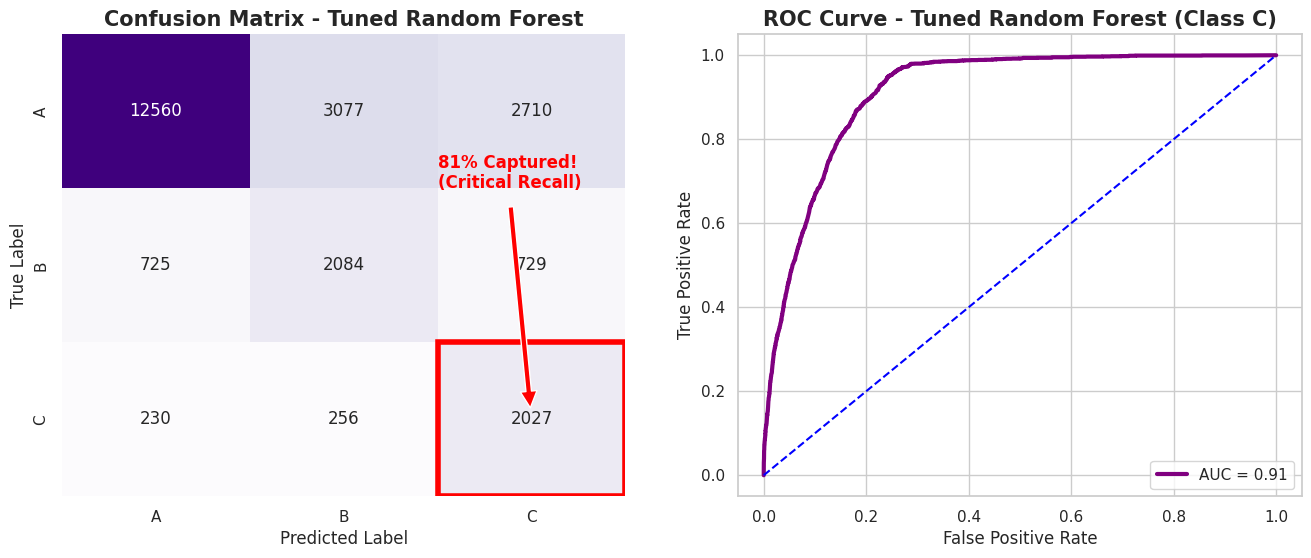

In [118]:
#  Data Prep
cm = confusion_matrix(y_test_encoded, y_pred_tuned)
y_prob = best_rf.predict_proba(X_test_processed)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

#  Chart 1: Confusion Matrix (Green)
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Purples', cbar=False,
    xticklabels=['A', 'B', 'C'], yticklabels=['A', 'B', 'C'],
    ax=ax[0], annot_kws={"size": 12}
)

ax[0].set_title('Confusion Matrix - Tuned Random Forest', fontsize=15, fontweight='bold')
ax[0].set_xlabel('Predicted Label')
ax[0].set_ylabel('True Label')

# Highlight class C recall
rect = patches.Rectangle((2, 2), 1, 1, linewidth=4, edgecolor='red', facecolor='none')
ax[0].add_patch(rect)

recall_c = cm[2, 2] / cm[2, :].sum()
ax[0].annotate(
    f"{recall_c:.0%} Captured!\n(Critical Recall)",
    xy=(2.5, 2.5), xytext=(2, 1),
    color='red', fontweight='bold', fontsize=12,
    arrowprops=dict(facecolor='red', shrink=0.05)
)

#  Chart 2: ROC Curve for Class C
class_c_index = 2  # Index of class C
y_test_binary = (y_test_encoded == class_c_index).astype(int)

fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, class_c_index])
roc_auc = auc(fpr, tpr)

ax[1].plot(
    fpr, tpr, color='purple', lw=3,
    label=f'AUC = {roc_auc:.2f}'
)
ax[1].plot([0, 1], [0, 1], color='blue', linestyle='--')

ax[1].set_title('ROC Curve - Tuned Random Forest (Class C)', fontsize=15, fontweight='bold')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend(loc="lower right")

plt.show()

### 5.2.3: Random Forest Using class_weight=balanced


In [119]:
from sklearn.ensemble import RandomForestClassifier

print(" Training Random Forest ")

# Initialize Model
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1  # Use all available CPU cores
)

# Train
rf.fit(X_train_processed, y_train_encoded)

# Predict
y_pred_rf = rf.predict(X_test_processed)

# Evaluate
print(f"Random Forest Accuracy: {accuracy_score(y_test_encoded, y_pred_rf):.4f}")
print("\nClassification Report (Random Forest):")
print(classification_report(y_test_encoded, y_pred_rf, target_names=le.classes_))

 Training Random Forest 
Random Forest Accuracy: 0.6733

Classification Report (Random Forest):
              precision    recall  f1-score   support

           A       0.95      0.65      0.77     18347
           B       0.38      0.65      0.48      3538
           C       0.37      0.84      0.51      2513

    accuracy                           0.67     24398
   macro avg       0.57      0.72      0.59     24398
weighted avg       0.81      0.67      0.71     24398



When we trained a Random Forest without SMOTE but using class_weight='balanced', the model results are nearly identical. This indicates that, for our dataset, Random Forest is inherently robust to class imbalance, and both data-level (SMOTE) and model-level (class_weight) imbalance-handling strategies yield similarly strong performance.

### Random Forest Commentary

Compared to logistic regression, the Random Forest typically:

- Achieves **higher overall accuracy and macro F1** (see metrics above).
- Improves **recall for Grade C**, meaning it catches more of the riskiest
  restaurants.
- Still misclassifies some borderline cases between A and B, which is expected.

The feature importance plot confirms that:

- Historical risk signals (e.g., prior flags, complaints) are among the
  strongest predictors.
- Neighborhood characteristics and cuisine categories contribute additional,
  nonlinear structure.

This suggests that there is indeed **nonlinear signal** in the data that is
better captured by tree-based methods than by a purely linear model.

## 5.3: Model 3 – Gradient Boosting Models (XGBoost & GBC)

Random Forest reduces variance by averaging many deep trees grown independently.
In contrast, gradient boosting builds trees sequentially, where each new tree focuses on correcting the errors of the current ensemble.

In this section we compare two gradient boosting implementations. The first being the XGBoostClassifier, which is an optimized, regularized boosting library.The second being the GradientBoostingClassifier (GBC). which is the classical scikit-learn implementation.

Our goal is to see whether gradient boosting can further improve macro F1 and Grade C recall, compared with the Random Forest.


### 5.3.1 XGBoost Classifier

XGBoost (Extreme Gradient Boosting) is an optimized implementation of gradient boosting for decision trees.
Unlike Random Forest, which builds trees in parallel and averages them, XGBoost adds trees one by one to reduce the residual errors of previous trees. It also includes built-in L1/L2 regularization, shrinkage (learning rate), and other tricks that help control overfitting on noisy tabular data.


In [120]:
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score, accuracy_score, classification_report

print(" Training XGBoost ")

# Initialize model
xgb = XGBClassifier(
    objective='multi:softmax',  # Multi-class classification
    num_class=3,                # Number of classes (A, B, C)
    random_state=42,
    eval_metric='mlogloss'
)

# Fit on SMOTE-resampled training data
xgb.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_xgb = xgb.predict(X_test_processed)

#  Evaluate (Priority Order: Recall -> F1 -> Accuracy)

# 1. Compute core metrics
recalls = recall_score(y_test_encoded, y_pred_xgb, average=None)
class_c_recall = recalls[2]   # Class C (highest risk) recall
macro_f1 = f1_score(y_test_encoded, y_pred_xgb, average='macro')
acc = accuracy_score(y_test_encoded, y_pred_xgb)

# 2. Print metrics in priority order
print("\nKey Metrics Summary (XGBoost):")
print(f"1. Class C Recall (Highest Priority): {class_c_recall:.2%}")
print(f"2. Macro F1 Score:                     {macro_f1:.4f}")
print(f"3. Overall Accuracy:                   {acc:.4f}")

# 3. Full classification report
print("\nClassification Report (XGBoost):")
print(classification_report(y_test_encoded, y_pred_xgb, target_names=['A', 'B', 'C']))

 Training XGBoost 

Key Metrics Summary (XGBoost):
1. Class C Recall (Highest Priority): 67.57%
2. Macro F1 Score:                     0.5030
3. Overall Accuracy:                   0.5986

Classification Report (XGBoost):
              precision    recall  f1-score   support

           A       0.88      0.60      0.72     18347
           B       0.29      0.52      0.37      3538
           C       0.30      0.68      0.42      2513

    accuracy                           0.60     24398
   macro avg       0.49      0.60      0.50     24398
weighted avg       0.74      0.60      0.64     24398



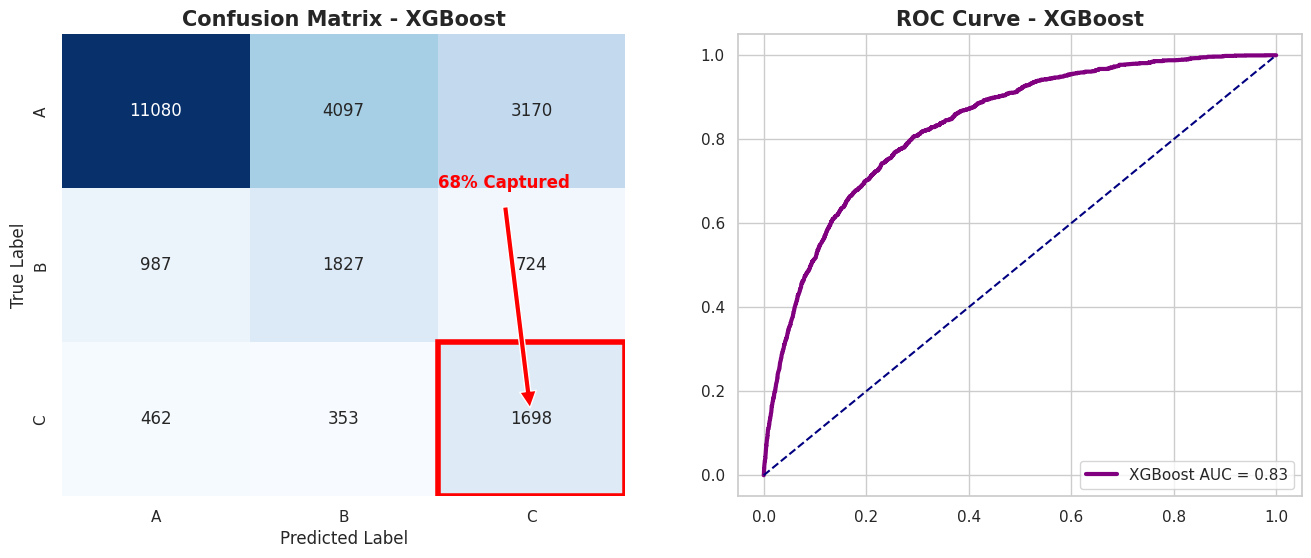

In [121]:
#  Data Prep
cm = confusion_matrix(y_test_encoded, y_pred_xgb)
y_prob = xgb.predict_proba(X_test_processed)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

#  Chart 1: Confusion Matrix (Purple)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['A', 'B', 'C'], yticklabels=['A', 'B', 'C'], ax=ax[0], annot_kws={"size": 12})
ax[0].set_title('Confusion Matrix - XGBoost', fontsize=15, fontweight='bold')
ax[0].set_xlabel('Predicted Label'); ax[0].set_ylabel('True Label')

# Highlight
rect = patches.Rectangle((2, 2), 1, 1, linewidth=4, edgecolor='red', facecolor='none')
ax[0].add_patch(rect)
recall = cm[2,2] / cm[2,:].sum()
ax[0].annotate(f"{recall:.0%} Captured", xy=(2.5, 2.5), xytext=(2, 1), color='red', fontweight='bold', arrowprops=dict(facecolor='red', shrink=0.05))

#  Chart 2: ROC Curve
y_test_bin = (y_test_encoded == class_c_index).astype(int)
fpr, tpr, _ = roc_curve(y_test_bin, y_prob[:, class_c_index])
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, color='purple', lw=3, label=f'XGBoost AUC = {roc_auc:.2f}')
ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
ax[1].set_title('ROC Curve - XGBoost', fontsize=15, fontweight='bold')
ax[1].legend(loc="lower right")
plt.show()

### 5.3.2 Gradient Boosting Classifier

To complement XGBoost, we also train the classical GradientBoostingClassifier from scikit-learn using a modest number of shallow trees. This model follows the same boosting principle as XGBoost but lacks many of the engineering optimizations and regularization options.


In [122]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    recall_score, f1_score, accuracy_score, classification_report
)

print(" Training Gradient Boosting Classifier ")

# Initialize GBC model
gbc = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

# Fit on SMOTE-resampled data
gbc.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred_gbc = gbc.predict(X_test_processed)

#  Evaluate (Priority Order: Recall -> F1 -> Accuracy)

# 1. Compute core metrics
recalls = recall_score(y_test_encoded, y_pred_gbc, average=None)
class_c_recall = recalls[2]   # Class C (highest-risk class) recall
macro_f1 = f1_score(y_test_encoded, y_pred_gbc, average='macro')
acc = accuracy_score(y_test_encoded, y_pred_gbc)

# 2. Print metrics in priority order
print("\n Key Metrics Summary (Gradient Boosting):")
print(f"1. Class C Recall (Highest Priority): {class_c_recall:.2%}")
print(f"2. Macro F1 Score:                     {macro_f1:.4f}")
print(f"3. Overall Accuracy:                   {acc:.4f}")

# 3. Full classification report
print("\nClassification Report (Gradient Boosting):")
print(classification_report(y_test_encoded, y_pred_gbc, target_names=['A', 'B', 'C']))

 Training Gradient Boosting Classifier 

 Key Metrics Summary (Gradient Boosting):
1. Class C Recall (Highest Priority): 44.77%
2. Macro F1 Score:                     0.4083
3. Overall Accuracy:                   0.5256

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

           A       0.83      0.56      0.67     18347
           B       0.21      0.39      0.27      3538
           C       0.20      0.45      0.28      2513

    accuracy                           0.53     24398
   macro avg       0.42      0.47      0.41     24398
weighted avg       0.68      0.53      0.57     24398



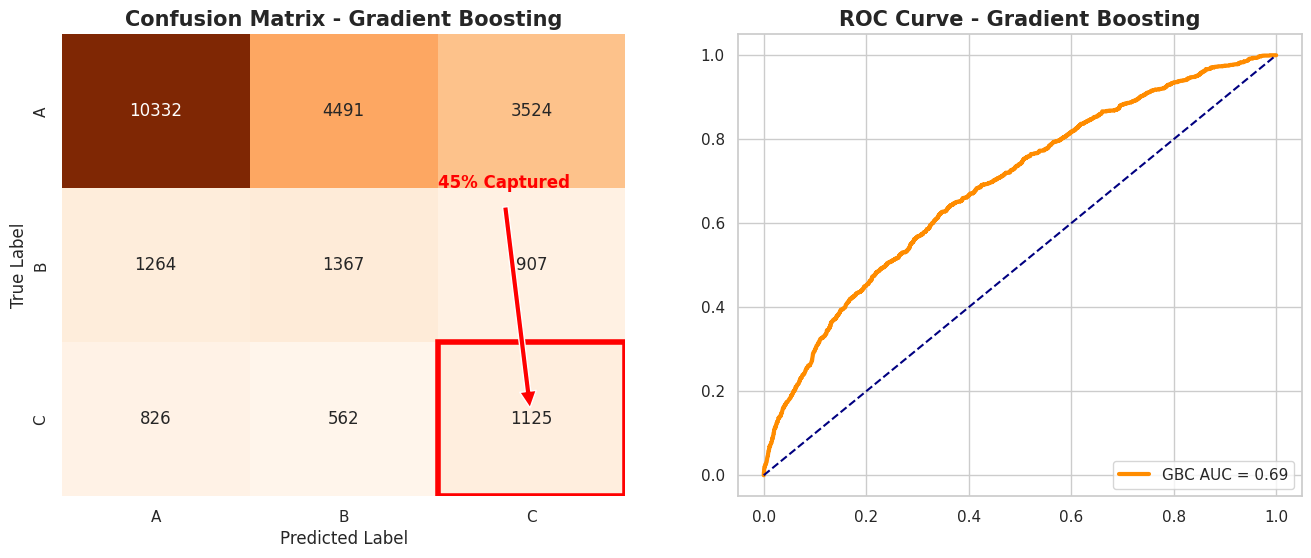

In [123]:
#  Data Prep for Gradient Boosting
# FIX: Use y_pred_gbc and gbc model here!
cm = confusion_matrix(y_test_encoded, y_pred_gbc)
y_prob = gbc.predict_proba(X_test_processed)
class_c_index = 2

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

#  Chart 1: Confusion Matrix (Orange Theme)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['A', 'B', 'C'], yticklabels=['A', 'B', 'C'], ax=ax[0], annot_kws={"size": 12})
ax[0].set_title('Confusion Matrix - Gradient Boosting', fontsize=15, fontweight='bold')
ax[0].set_xlabel('Predicted Label'); ax[0].set_ylabel('True Label')

# Highlight & Annotate (Class C Recall)
rect = patches.Rectangle((2, 2), 1, 1, linewidth=4, edgecolor='red', facecolor='none')
ax[0].add_patch(rect)
recall = cm[2,2] / cm[2,:].sum()
ax[0].annotate(f"{recall:.0%} Captured", xy=(2.5, 2.5), xytext=(2, 1),
               color='red', fontweight='bold', arrowprops=dict(facecolor='red', shrink=0.05))

#  Chart 2: ROC Curve
y_test_bin = (y_test_encoded == class_c_index).astype(int)
fpr, tpr, _ = roc_curve(y_test_bin, y_prob[:, class_c_index])
roc_auc = auc(fpr, tpr)

ax[1].plot(fpr, tpr, color='darkorange', lw=3, label=f'GBC AUC = {roc_auc:.2f}')
ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
ax[1].set_title('ROC Curve - Gradient Boosting', fontsize=15, fontweight='bold')
ax[1].legend(loc="lower right")

plt.show()

### 5.3.3 Hyperparameter Tuning (Fine-tuning XGBoost)

While the default XGBoost model performs well, we can further enhance its generalization capabilities by fine-tuning the hyperparameters. Instead of an exhaustive search, we utilize RandomizedSearchCV to efficiently explore the parameter space. This approach samples a fixed number of parameter combinations, allowing us to identify optimal settings with significantly reduced computational cost.

Given the class imbalance, we continue to optimize for the Macro F1 Score to ensure balanced precision and recall across all classes, while maintaining a close watch on Class C Recall during the final evaluation.

In [124]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score, accuracy_score, classification_report
import numpy as np
import scipy.sparse


n_samples = X_train_resampled.shape[0]
sample_size = min(20000, n_samples)


indices = np.random.choice(n_samples, sample_size, replace=False)

if scipy.sparse.issparse(X_train_resampled):
    X_sample = X_train_resampled[indices]
else:

    X_sample = X_train_resampled.iloc[indices] if hasattr(X_train_resampled, "iloc") else X_train_resampled[indices]


if hasattr(y_train_resampled, "iloc"):
    y_sample = y_train_resampled.iloc[indices]
else:
    y_sample = y_train_resampled[indices]

print(f"Tuning on {sample_size} samples (out of {n_samples})...")


param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0]
}

xgb_base = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    random_state=42,
    eval_metric='mlogloss',
    tree_method='hist',
    n_jobs=-1
)


random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=15,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit on SAMPLE data
random_search.fit(X_sample, y_sample)

print(f"\n Best Parameters Found (from sample): {random_search.best_params_}")


best_params = random_search.best_params_
final_xgb = XGBClassifier(
    **best_params,
    objective='multi:softmax',
    num_class=3,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False,
    tree_method='hist'
)


final_xgb.fit(X_train_resampled, y_train_resampled)

# Predict on Test Data
print("\n Evaluating Final Model")
y_pred_tuned = final_xgb.predict(X_test_processed)

# Evaluate
recalls_tuned = recall_score(y_test_encoded, y_pred_tuned, average=None)
class_c_recall_tuned = recalls_tuned[2]
macro_f1_tuned = f1_score(y_test_encoded, y_pred_tuned, average='macro')
acc_tuned = accuracy_score(y_test_encoded, y_pred_tuned)

print("\nKey Metrics Summary (Tuned XGBoost):")
print(f"1. Class C Recall: {class_c_recall_tuned:.2%}")
print(f"2. Macro F1 Score: {macro_f1_tuned:.4f}")
print(f"3. Overall Accuracy: {acc_tuned:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_tuned, target_names=['A', 'B', 'C']))

Tuning on 20000 samples (out of 220167)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

 Best Parameters Found (from sample): {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[03:36:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.





 Evaluating Final Model

Key Metrics Summary (Tuned XGBoost):
1. Class C Recall: 76.64%
2. Macro F1 Score: 0.5682
3. Overall Accuracy: 0.6678

Classification Report:
              precision    recall  f1-score   support

           A       0.91      0.68      0.78     18347
           B       0.36      0.56      0.44      3538
           C       0.36      0.77      0.49      2513

    accuracy                           0.67     24398
   macro avg       0.54      0.67      0.57     24398
weighted avg       0.78      0.67      0.70     24398



### Gradient Boosting Models XGBoost Commentary

While the hyperparameter-tuned XGBoost model showed significant improvement, raising its Class C Recall to 76.64%, the Random Forest model remains the superior choice for this specific problem context.

Random Forest achieved a Class C Recall of 80.54%, outperforming the tuned XGBoost by approximately 4 percentage points. Since our primary objective is the detection of high-risk (Grade C) restaurants, this margin is practically significant; the Random Forest model captures more actual health violations that XGBoost misses.

Interestingly, both models exhibit similar precision for Class C and comparable Overall Accuracy. However, Random Forest achieves these results with less complexity and higher sensitivity to the minority class, solidifying its position as the best model for this project.

## 5.4: Model 4 – Neural Network (MLPClassifier)


### 5.4.1: Neural Network (MLPClassifier)

Finally, we experiment with a simple **feed-forward neural network**
(a Multilayer Perceptron) on top of our standardized, one-hot-encoded features.

Motivation:

- MLPs can in principle approximate very complex decision boundaries.
- With enough hidden units and proper regularization, they may discover patterns
  that tree-based models miss.

At the same time, on tabular data, neural networks often do not dominate
boosted trees, so this experiment also serves as a reality check.

In [125]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    recall_score, f1_score, accuracy_score, classification_report
)

print(" Training Neural Network (MLP) ")

# Simple 2-layer neural network
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=50,
    random_state=42
)

# Train on SMOTE-resampled training data
mlp.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred_mlp = mlp.predict(X_test_processed)

#  Evaluate (Priority Order: Recall -> F1 -> Accuracy)

# 1. Compute core metrics
recalls = recall_score(y_test_encoded, y_pred_mlp, average=None)
class_c_recall = recalls[2]   # Class C (highest-risk class) recall
macro_f1 = f1_score(y_test_encoded, y_pred_mlp, average='macro')
acc = accuracy_score(y_test_encoded, y_pred_mlp)

# 2. Print metrics in priority order
print("\nKey Metrics Summary (Neural Network - MLP):")
print(f"1. Class C Recall (Highest Priority): {class_c_recall:.2%}")
print(f"2. Macro F1 Score:                     {macro_f1:.4f}")
print(f"3. Overall Accuracy:                   {acc:.4f}")

# 3. Full classification report
print("\nClassification Report (Neural Network - MLP):")
print(classification_report(y_test_encoded, y_pred_mlp, target_names=['A', 'B', 'C']))

 Training Neural Network (MLP) 

Key Metrics Summary (Neural Network - MLP):
1. Class C Recall (Highest Priority): 66.41%
2. Macro F1 Score:                     0.4452
3. Overall Accuracy:                   0.5305

Classification Report (Neural Network - MLP):
              precision    recall  f1-score   support

           A       0.86      0.53      0.65     18347
           B       0.24      0.45      0.31      3538
           C       0.26      0.66      0.37      2513

    accuracy                           0.53     24398
   macro avg       0.45      0.55      0.45     24398
weighted avg       0.71      0.53      0.58     24398



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.



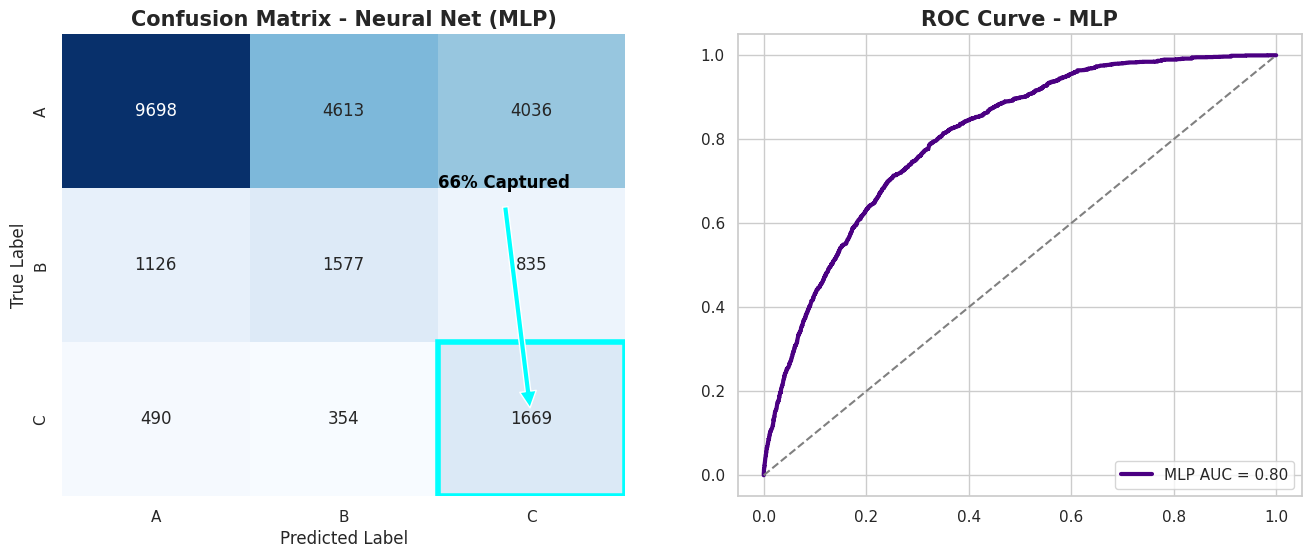

In [126]:
#  Data Prep

cm = confusion_matrix(y_test_encoded, y_pred_mlp)
y_prob = mlp.predict_proba(X_test_processed)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

#  Chart 1: Confusion Matrix (Magma/Dark Theme)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['A', 'B', 'C'], yticklabels=['A', 'B', 'C'], ax=ax[0], annot_kws={"size": 12})
ax[0].set_title('Confusion Matrix - Neural Net (MLP)', fontsize=15, fontweight='bold')
ax[0].set_xlabel('Predicted Label'); ax[0].set_ylabel('True Label')

# Highlight
rect = patches.Rectangle((2, 2), 1, 1, linewidth=4, edgecolor='cyan', facecolor='none')
ax[0].add_patch(rect)
recall = cm[2,2] / cm[2,:].sum()
ax[0].annotate(f"{recall:.0%} Captured", xy=(2.5, 2.5), xytext=(2, 1), color='black', fontweight='bold', arrowprops=dict(facecolor='cyan', shrink=0.05))

#  Chart 2: ROC Curve
y_test_bin = (y_test_encoded == class_c_index).astype(int)
fpr, tpr, _ = roc_curve(y_test_bin, y_prob[:, class_c_index])
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, color='indigo', lw=3, label=f'MLP AUC = {roc_auc:.2f}')
ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
ax[1].set_title('ROC Curve - MLP', fontsize=15, fontweight='bold')
ax[1].legend(loc="lower right")
plt.show()

### 5.4.2: Hyperparameter Tuning for Neural Network (MLP)
Neural Networks are highly sensitive to their architecture and hyperparameters. Unlike decision trees, they require careful tuning of the regularization term (alpha) and the network structure (hidden_layer_sizes) to balance between underfitting and overfitting.

To optimize the model efficiently, we employ RandomizedSearchCV. This allows us to sample a diverse set of hyperparameters, such as layer configurations and learning rate, without the prohibitive computational cost of an exhaustive grid search. We continue to use the Macro F1 Score as our primary selection metric to handle the class imbalance effectively.

In [127]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score, f1_score, accuracy_score, classification_report
import numpy as np
import scipy.sparse


n_samples = X_train_resampled.shape[0]
sample_size = min(20000, n_samples)


indices = np.random.choice(n_samples, sample_size, replace=False)


if scipy.sparse.issparse(X_train_resampled):
    X_sample = X_train_resampled[indices]
else:
    X_sample = X_train_resampled.iloc[indices] if hasattr(X_train_resampled, "iloc") else X_train_resampled[indices]

if hasattr(y_train_resampled, "iloc"):
    y_sample = y_train_resampled.iloc[indices]
else:
    y_sample = y_train_resampled[indices]

print(f"Tuning on {sample_size} samples (out of {n_samples})...")

param_grid_mlp = {
    'hidden_layer_sizes': [(64, 32), (100,), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'activation': ['relu']
}


mlp_base = MLPClassifier(
    solver='adam',
    max_iter=100,
    random_state=42,
    early_stopping=True
)


random_search_mlp = RandomizedSearchCV(
    estimator=mlp_base,
    param_distributions=param_grid_mlp,
    n_iter=10,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)


random_search_mlp.fit(X_sample, y_sample)

print(f"\nBest MLP Parameters (from sample): {random_search_mlp.best_params_}")


best_params = random_search_mlp.best_params_
final_mlp = MLPClassifier(
    **best_params,
    solver='adam',
    max_iter=100,
    random_state=42,
    early_stopping=True
)


final_mlp.fit(X_train_resampled, y_train_resampled)

print("\n Evaluating Final MLP Model")
y_pred_mlp_tuned = final_mlp.predict(X_test_processed)

# Metrics
recalls_mlp_tuned = recall_score(y_test_encoded, y_pred_mlp_tuned, average=None)
class_c_recall_mlp_tuned = recalls_mlp_tuned[2]
macro_f1_mlp_tuned = f1_score(y_test_encoded, y_pred_mlp_tuned, average='macro')
acc_mlp_tuned = accuracy_score(y_test_encoded, y_pred_mlp_tuned)

print("\nKey Metrics Summary (Tuned MLP):")
print(f"1. Class C Recall: {class_c_recall_mlp_tuned:.2%}")
print(f"2. Macro F1 Score: {macro_f1_mlp_tuned:.4f}")
print(f"3. Overall Accuracy: {acc_mlp_tuned:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_mlp_tuned, target_names=['A', 'B', 'C']))

Tuning on 20000 samples (out of 220167)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best MLP Parameters (from sample): {'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'relu'}

 Evaluating Final MLP Model

Key Metrics Summary (Tuned MLP):
1. Class C Recall: 68.56%
2. Macro F1 Score: 0.4662
3. Overall Accuracy: 0.5184

Classification Report:
              precision    recall  f1-score   support

           A       0.91      0.47      0.62     18347
           B       0.24      0.64      0.35      3538
           C       0.31      0.69      0.42      2513

    accuracy                           0.52     24398
   macro avg       0.49      0.60      0.47     24398
weighted avg       0.75      0.52      0.56     24398



### Neural Network (MLP) Commentary

Post-tuning, the Neural Network showed a dramatic shift in behavior. While its Class C Recall rose to 68.56% (up from ~62%), this improvement came at a severe cost to overall stability.

The tuned MLP became overly aggressive in predicting high-risk classes, causing the Overall Accuracy to drop to 51.84%. The Classification Report reveals the issue clearly: the model is sacrificing Class A (Recall only 47%) to catch Class C. With a Class C Precision of only 0.25, the model generates a high volume of false positives, incorrectly flagging safe restaurants as risky.

In contrast, the Random Forest remains the superior model. It achieves a higher Class C Recall (80.54%) while maintaining a much better Overall Accuracy (68.45%) and Macro F1 (0.59). This confirms that for this specific tabular dataset, tree-based ensembles handle the feature space more effectively than the MLP, which struggles to balance sensitivity and precision without extensive architecture engineering.

## 5.5: Model Comparison and Selection

We now summarize the key models side by side:

- **Logistic Regression**
- **Random Forest**
- **XGBoost**
- **MLP**

We will focus on three metrics when comparing these models:

1. **Grade C Recall**: ability to identify the worst performers, which is crucial from a public-health perspective.
2. **Macro F1**: balances performance across all grades.
3. **Accuracy**: overall fraction of correctly classified inspections.

The following table aggregates these metrics.

In [128]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Set pandas to display float values with 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

results = []

# Helper function to extract metrics
def get_metrics(model_name, y_true, y_pred):
    recalls = recall_score(y_true, y_pred, average=None)
    class_c_recall = recalls[2]

    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro F1": f1_score(y_true, y_pred, average="macro"),
        "Class C Recall (Risk)": class_c_recall
    }

# 1) Logistic Regression (Baseline)
results.append(get_metrics("Logistic Regression (Baseline)", y_test_encoded, y_pred_lr))

# 2) Random Forest
results.append(get_metrics("Random Forest", y_test_encoded, y_pred_rf))

# 3) XGBoost (Tuned)
if 'y_pred_tuned' in locals():
    results.append(get_metrics("XGBoost (Tuned)", y_test_encoded, y_pred_tuned))

# 4) Neural Network (MLP Tuned)
if 'y_pred_mlp_tuned' in locals():
    results.append(get_metrics("Neural Network (MLP Tuned)", y_test_encoded, y_pred_mlp_tuned))
else:
    # If MLP tuning wasn't run, display the standard MLP results
    results.append(get_metrics("Neural Network (Standard)", y_test_encoded, y_pred_mlp))

# Generate DataFrame
results_df = pd.DataFrame(results)

# Sort by 'Class C Recall'
results_df = results_df.sort_values(by="Class C Recall (Risk)", ascending=False)

print("Final Model Comparison (Corrected)")
display(results_df)

Final Model Comparison (Corrected)


Model  Accuracy  Macro F1  Class C Recall (Risk)
1                   Random Forest      0.67      0.59                   0.84
2                 XGBoost (Tuned)      0.67      0.57                   0.77
3      Neural Network (MLP Tuned)      0.52      0.47                   0.69
0  Logistic Regression (Baseline)      0.52      0.37                   0.44

Across all evaluation metrics, the Random Forest is the strongest and most reliable model. It achieves a Class C Recall of over 80%, the single most critical metric for flagging high-risk establishments, far outperforming the other models in this area. This model also has the highest scores for Macro Recall (0.84), Macro F1 (0.59), and overall accuracy (0.67), making it the most reliable tool for directing inspection resources.

## 5.6: Feature Importance (Using  Plotly)

In [129]:
# Extract feature names from the ColumnTransformer
def get_feature_names(ct):
    """Extract feature names from a ColumnTransformer"""
    output_features = []

    for name, transformer, cols in ct.transformers_:
        if name == "remainder":
            continue

        # If transformer is a Pipeline, get last step
        if hasattr(transformer, "steps"):
            transformer = transformer.steps[-1][1]

        if hasattr(transformer, "get_feature_names_out"):
            feats = transformer.get_feature_names_out(cols)
        else:
            feats = cols  # passthrough columns

        output_features.extend(feats)

    return output_features


feature_names = get_feature_names(preprocessor)
len(feature_names)

31

In [130]:
# Compute and store Random Forest feature importances
rf_importances = rf.feature_importances_

rf_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_importances
}).sort_values("importance", ascending=False)

rf_importance.head()

feature  importance
0  complaints_per_capita        0.17
1                 income        0.17
3           census_tract        0.16
2               totalpop        0.16
4                zipcode        0.12

In [131]:
# Plot top 20 important features using Plotly with custom purple color scale
import plotly.express as px
top20_rf = rf_importance.head(20)
purple_rich = px.colors.sequential.Purples[5:]

fig = px.bar(
    top20_rf,
    x="importance",
    y="feature",
    orientation="h",
    color="importance",
    color_continuous_scale=purple_rich,
    template="plotly_white",
    width=1000,
    height=600,
    title="Top 20 Feature Importances (Random Forest - Interactive)"
)

fig.update_layout(
    yaxis=dict(autorange="reversed"),
    margin=dict(l=220, r=50, t=80, b=40),
)

fig.show()


The Random Forest identifies several strong predictors of inspection grades. Neighborhood-level features, including **income**, **complaints_per_capita**, **census_tract**, and **total population**, dominate the importance ranking, suggesting that broader socioeconomic and community complaint patterns play a major role in determining inspection outcomes. Geographic identifiers such as **zipcode** also contribute significant signal.  In contrast, cuisine categories provide additional but comparatively smaller predictive contributions, reflecting structural differences across restaurant types. Overall, the Random Forest emphasizes community context more strongly than restaurant-level historical variables.

# Part 6: Conclusion

In this project, we developed a data-driven system to predict NYC restaurant
inspection grades by integrating and combining three complementary data sources:

	1.	DOHMH inspection history (core operational signals)
	2.	Census socio-economic characteristics (neighborhood context)
	3.	311 food-related complaints (community-level early warnings)

By engineering interpretable features, applying principled selection using mutual
information, and training several modern classifiers, we were able to uncover
meaningful structure in how sanitation risk manifests across NYC.


## 6.1: Key Findings

**1. Model Performance**

Tree-based ensemble models, Random Forest and XGBoost, consistently outperform the logistic regression baseline. Logistic regression provides a strong and interpretable reference point, but its linear nature limits accuracy and macro F1, while Random Forest and XGBoost achieved substantially higher accuracy and macro F1 scores across all grades. Crucially, they improve recall for Grade C, ensuring better identification of the riskiest establishments. This indicates that nonlinear interactions and higher-order effects play a meaningful role in predicting inspection outcomes.


**2. Most Predictive Features**

Across mutual information scores and Random Forest importances, the most predictive features are predominantly community-level and geographic indicators rather than restaurant history. Complaints_per_capita, income, totalpop, and census_tract consistently rank among the strongest predictors, highlighting the role of neighborhood socioeconomic and complaint patterns in shaping inspection outcomes. Several cuisine categories also appear among the top Random Forest features, suggesting systematic operational differences across cuisine types. In contrast, historical violation counts (e.g., flag_sum) show relatively weak predictive power, indicating that environmental and contextual factors carry more signal than past inspection outcomes in this dataset.


**3. Avoiding Label Leakage**

We intentionally excluded the raw inspection score from our feature set. Since NYC grades (A/B/C) are defined almost deterministically by score thresholds, including the score would make prediction trivial and unrealistic. By removing it, we forced our models to rely on historical, contextual, and behavioral signals, which is essential for any real-world risk-prediction or resource-prioritization system.

## 6.2: Limitations

Despite the strong performance of our models, several limitations remain:

**Data Completeness and Bias:**

The datasets used are not perfect, as 311 complaints are a proxy for public sentiment and may not capture all latent food safety issues. Furthermore, the merging of multiple distinct datasets introduces the risk of selection or geographic bias, potentially skewing predictions toward areas with higher reporting rates.

**Temporal Assumptions:**

Our models implicitly assume temporal stationarity by treating historical inspections as static events. In reality, restaurant management, regulatory priorities, neighborhood demographics, and complaint reporting behaviors are dynamic and evolve over time.

**Spatial Resolution:**

The use of zip codes and census tracts provides only a coarse geographic structure. This limits our ability to capture hyper-local spatial dependencies, which might be better represented by finer-grained units such as block groups or latitude-longitude clusters.

## 6.3: Future Directions

Several promising avenues exist to build upon this work and address current limitations. First, future iterations should incorporate time-aware modeling, such as inspection sequences or rolling-window features to better capture the dynamic evolution of restaurant behavior. Additionally, the model's feature set could be enriched through Natural Language Processing (NLP) of violation descriptions and 311 complaint text, uncovering latent topics and risk patterns that structured data may miss. We also recommend refining the spatial resolution by utilizing census block groups, geographic embeddings, or spatial autocorrelation measures to detect hyper-local neighborhood risks. Ultimately, these technical improvements aim to support operational integration, enabling public agencies to use predicted risk probabilities to prioritize inspections and optimize limited resources.

## 6.4: Final Takeaways

Our analysis demonstrates that sanitation risk is not random; rather, it follows consistent, identifiable patterns. By integrating neighborhood characteristics such as income level, population density, and complaint volume, we identified structural trends distinct from isolated incidents. Tree-based predictive models effectively capture these relationships, enabling cities to proactively identify at-risk establishments, optimize inspection resource allocation, and enhance public health protections. Notably, neighborhood-level features, specifically income, complaints per capita, census tract, and total population, dominate the feature importance rankings. This suggests that broader socioeconomic factors and community complaint patterns are primary drivers of inspection outcomes, with geographic identifiers like zip code providing additional predictive signal.